In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

from sklearn import preprocessing

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

# Statistical Analysis

In [2]:
# Get Column values: max, min, count, average, standard deviation, first, last
def get_col_max(df, col):
    return df[col].max()

def get_col_min(df, col):
    return df[col].min()

def get_col_count(df, col):
    return df[col].count()

def get_col_avg(df, col):
    return df[col].mean()

def get_col_std(df, col):
    return df[col].std()

def get_first(df):
    return df.iloc[0]

def get_last(df):
    return df.iloc[-1]

# Functions For Preprocessing

In [3]:
# convert date to datetime
def convert_date(df, column, date_format='%y%m%d'):
    copy_df = df.copy()
    copy_df[column] = pd.to_datetime(copy_df[column], format=date_format)
    return copy_df

In [4]:
# Encode column of dataframe
def encode_column(original_df, column):
    
    df = original_df.copy()
    le = preprocessing.LabelEncoder()
    le.fit(df[column].unique())
    df[column] = le.transform(df[column])
    
    return df

In [5]:
# Correlation matrix (only triangle)
def get_df_correlation(df, figure_size=(11, 9)):
    # Get correlation matrix
    corr = df.corr()

    # Mask for upper triangle
    triangle_mask = np.zeros_like(corr, dtype=np.bool)
    triangle_mask[np.triu_indices_from(triangle_mask)] = True
    
    # Size of plot
    plt.subplots(figsize=figure_size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=triangle_mask, cmap=cmap, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

In [6]:
# Bar plot for the chosen column of the provided dataframe
def bar_plot(df, col):
    '''Present the given feature of the given df as a barplot,
    using count as the y value'''
    col_count = '%s_count' % col
    agg_df = df.groupby([col]).agg({
                   col: ['count']
               }).reset_index()
    agg_df.columns = [col, col_count]
    sns.barplot(x=agg_df[col], y=agg_df[col_count], palette="rocket")
    # ax1.axhline(0, color="k", clip_on=False)
    plt.show()

In [7]:
# Scatter plot for 2 chosen columns of the provided dataframe
def scatter_plot_two_cols(df, x_col, y_col, figure_size=(11, 9)):
    
    # Size of plot
    plt.subplots(figsize=figure_size)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

    sns.scatterplot(data=df, x=x_col, y=y_col, hue='status',palette=cmap, sizes=(47,47))
    plt.show()

In [8]:
# Bubble plot for 3 chosen columns of the provided dataframe
def bubble_plot_three_cols(df, x_col, y_col, hue_size_col):
    
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_size_col, size=hue_size_col, palette=cmap, sizes=(50, 300))

    plt.show()

In [9]:
# Histogram for Features of dataframe
def get_features_histogram(df, figure_size=(20, 25)):

    fig = plt.figure(figsize=figure_size)
    loan = df[df.status==1]
    do_not_loan = df[df.status==-1]
    j = 0

    for i in range(len(df.columns)):
        plt.subplot(math.ceil(len(df.columns) / 3), 3, j+1)
        j += 1
        sns.distplot(loan.iloc[:, i], color='g', label = 'loan',
                    kde = False if len(loan.iloc[:, i].unique()) == 1 else True)
        sns.distplot(do_not_loan.iloc[:, i], color='r', label = 'no loan',
                    kde = False if len(do_not_loan.iloc[:, i].unique()) == 1 else True)
        plt.legend(loc='best')

    fig.suptitle('Feature Analysis')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

## Missing Values

In [10]:
# Missing Values summary of provided dataset
def missing_values(dataset):
    display(dataset.isnull().mean())

In [11]:
# Missing Values Cleaning: if over the defined threshold the column/row is deleted
def missing_values_cleaning(df, threshold=0.7):
    
    # Drop columns with missing value percentage > threshold
    df = df[df.columns[df.isnull().mean() < threshold]]

    # Drop rows    with missing value percentage > threshold
    df = df.loc[df.isnull().mean(axis=1) < threshold]
    
    return df

In [12]:
# Missing Values Treatment: for numerical columns, replace with custom value or median 
def clean_numerical_missing_values(dataset, replacer=None):
    
    dataset = dataset.fillna(replacer if replacer is not None else dataset.median())

    return dataset

In [13]:
# Missing Values Treatment: for categorical columns, replace with custom value or max value (that isn't null)
def clean_categorical_missing_values(dataset, col, replacer=None):

    dataset[col].fillna(replacer if replacer is not None else dataset[col].value_counts().idxmax(), inplace=True)
    
    return dataset

## Log Transform

In [14]:
def log_transform(series):
    min_val = series.min()
    return (series - min_val + 1).transform(np.log)

# Feature Selection Algorithms

## Filter Method - Correlation Threshold

In [15]:
filter_features = []

def select_features_FF(origin_df, corr_threshold= 0.15, debug=False):

    # Only run in train
    if len(filter_features) is 0:
        status_corr = origin_df.corr().tail(1).drop(['status'], axis=1)
        if debug:
            print(' ::: Filter Feature Selection Output :::')
            print(' > Correlation between status and other features')
            display(status_corr)

        status_corr = status_corr.loc[:, (abs(status_corr) > corr_threshold).any()]

        if debug:
            print('The chosen features whose correlatino value is above the threshold:')
            display(status_corr)

        for col in status_corr:
            filter_features.append(col)

## Wrapper Method - Logistic Regression
#### Parameters: max_iter=1000, k_features='best', forward=True, floating=False,verbose=2, scoring='roc_auc', n_jobs=-1, cv=0

In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression as LGR

In [17]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

wrapper_features = []

def analyse_sfs(sfs1):
    display(sfs1.subsets_)
    print('-----')
    display(sfs1.get_metric_dict())
    print('-----')
    
    fig1 = plot_sfs(sfs1.get_metric_dict(confidence_interval=0.95), kind='std_err')
    plt.title('Sequential Forward Selection')
    plt.grid()
    plt.show()
    
    print("-------------------------")

    display(sfs1.k_feature_names_, sfs1.k_feature_idx_)

    print("-------------------------")
    
    dfy_ = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
    dfy_[["feature_idx", "avg_score"]]
    wrapper_features = dfy_[["feature_idx"]]

In [18]:
def select_features_wrapper(origin_df, dubug=False):
    
    features = origin_df.drop(['loan_id', 'status'], axis=1).select_dtypes(include=np.number).columns
    
    X = origin_df.drop(['loan_id', 'status'], axis=1).select_dtypes(include=np.number)
    y = origin_df['status']
    
    print("X columns:")
    print(X.dtypes)
    print("Y:")
    print(y)
    print()
    
    # Only run in train
    sfs1 = SFS(LGR(max_iter=1000),
               k_features='best',
               forward=True,
               floating=False,
               verbose=2,
               scoring='roc_auc', #roc_auc #accuracy
               n_jobs=-1,
               cv=0)
    
    sfs1 = sfs1.fit(X, y, custom_feature_names=features)
    
    analyse_sfs(sfs1)

# Feature Engineering

## Load data

In [19]:
# Loading the tables both used for train and test
account_df = pd.read_csv('./raw/account.csv', delimiter=";")
disp_df = pd.read_csv('./raw/disp.csv', delimiter=';')
client_df = pd.read_csv('./raw/client.csv', delimiter=';')
demogra_df = pd.read_csv('./raw/district.csv', delimiter=';')

# Loading the train tables
loan_df = pd.read_csv('./raw/loan_dev.csv', delimiter=';')
card_df = pd.read_csv('./raw/card_dev.csv', delimiter=';')
trans_df = pd.read_csv('./raw/trans_dev.csv', delimiter=';')

# Loading the test tables
loan_test_df = pd.read_csv('./raw/loan_comp.csv', delimiter=';')
card_test_df = pd.concat([pd.read_csv('./raw/card_comp.csv', delimiter=';'), card_df])
trans_test_df = pd.concat([pd.read_csv('./raw/trans_comp.csv', delimiter=';'), trans_df])

print('\n\n\t ACCOUNT TABLE')
display(account_df.head())

print('\n\n\t DISPOSITION TABLE')
display(disp_df.head())

print('\n\n\t CLIENT TABLE')
display(client_df.head())

print('\n\n\tDEMOGRAPHIC TABLE')
display(demogra_df.head())

print('\n\n\t LOAN TABLE')
display(loan_df.head())

print('\n\n\t CREDIT CARD TABLE')
display(card_df.head())

print('\n\n\tTRANSACTIONS TABLE')
display(trans_df.head())



	 ACCOUNT TABLE


account_id  district_id         frequency    date
0         576           55  monthly issuance  930101
1        3818           74  monthly issuance  930101
2         704           55  monthly issuance  930101
3        2378           16  monthly issuance  930101
4        2632           24  monthly issuance  930102



	 DISPOSITION TABLE


disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT
3        4          4           3      OWNER
4        5          5           3  DISPONENT



	 CLIENT TABLE


client_id  birth_number  district_id
0          1        706213           18
1          2        450204            1
2          3        406009            1
3          4        561201            5
4          5        605703            5



	DEMOGRAPHIC TABLE


code         name            region  no. of inhabitants  \
0      1  Hl.m. Praha           Prague             1204953   
1      2      Benesov  central Bohemia               88884   
2      3       Beroun  central Bohemia               75232   
3      4       Kladno  central Bohemia              149893   
4      5        Kolin  central Bohemia               95616   

   no. of municipalities with inhabitants < 499   \
0                                              0   
1                                             80   
2                                             55   
3                                             63   
4                                             65   

   no. of municipalities with inhabitants 500-1999  \
0                                                0   
1                                               26   
2                                               26   
3                                               29   
4                                               30   

   no. of municipalities with inhabitants 2000-9999   \
0                                                  0   
1                                                  6   
2                                                  4   
3                                                  6   
4                                                  4   

   no. of municipalities with inhabitants >10000   no. of cities   \
0                                               1               1   
1                                               2               5   
2                                               1               5   
3                                               2               6   
4                                               1               6   

   ratio of urban inhabitants   average salary  unemploymant rate '95   \
0                        100.0            12541                   0.29   
1                         46.7             8507                   1.67   
2                         41.7             8980                   1.95   
3                         67.4             9753                   4.64   
4                         51.4             9307                   3.85   

   unemploymant rate '96   no. of enterpreneurs per 1000 inhabitants   \
0                    0.43                                         167   
1                    1.85                                         132   
2                    2.21                                         111   
3                    5.05                                         109   
4                    4.43                                         118   

  no. of commited crimes '95   no. of commited crimes '96   
0                       85677                        99107  
1                        2159                         2674  
2                        2824                         2813  
3                        5244                         5892  
4                        2616                         3040



	 LOAN TABLE


loan_id  account_id    date  amount  duration  payments  status
0     5314        1787  930705   96396        12      8033      -1
1     5316        1801  930711  165960        36      4610       1
2     6863        9188  930728  127080        60      2118       1
3     5325        1843  930803  105804        36      2939       1
4     7240       11013  930906  274740        60      4579       1



	 CREDIT CARD TABLE


card_id  disp_id     type  issued
0     1005     9285  classic  931107
1      104      588  classic  940119
2      747     4915  classic  940205
3       70      439  classic  940208
4      577     3687  classic  940215



	TRANSACTIONS TABLE


trans_id  account_id    date    type                     operation  \
0   1548749        5270  930113  credit                credit in cash   
1   1548750        5270  930114  credit  collection from another bank   
2   3393738       11265  930114  credit                credit in cash   
3   3122924       10364  930117  credit                credit in cash   
4   1121963        3834  930119  credit                credit in cash   

    amount  balance k_symbol bank     account  
0    800.0    800.0      NaN  NaN         NaN  
1  44749.0  45549.0      NaN   IJ  80269753.0  
2   1000.0   1000.0      NaN  NaN         NaN  
3   1100.0   1100.0      NaN  NaN         NaN  
4    700.0    700.0      NaN  NaN         NaN

# Individual preprocessing of tables

Raw loans representation


loan_id  account_id    date  amount  duration  payments  status
0       5314        1787  930705   96396        12      8033      -1
1       5316        1801  930711  165960        36      4610       1
2       6863        9188  930728  127080        60      2118       1
3       5325        1843  930803  105804        36      2939       1
4       7240       11013  930906  274740        60      4579       1
..       ...         ...     ...     ...       ...       ...     ...
323     6818        9030  961212  155616        48      3242       1
324     5625        3189  961215  222180        60      3703      -1
325     6805        8972  961221   45024        48       938       1
326     7233       10963  961225  115812        36      3217       1
327     7308       11362  961227  129408        24      5392       1

[328 rows x 7 columns]

Raw loans correlations


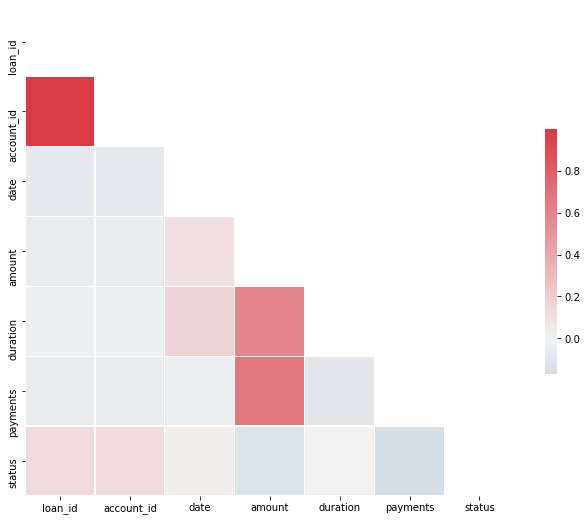

No past history regarding loans.
There is an obvious and expected correlation between the duration, amount and payments columns.


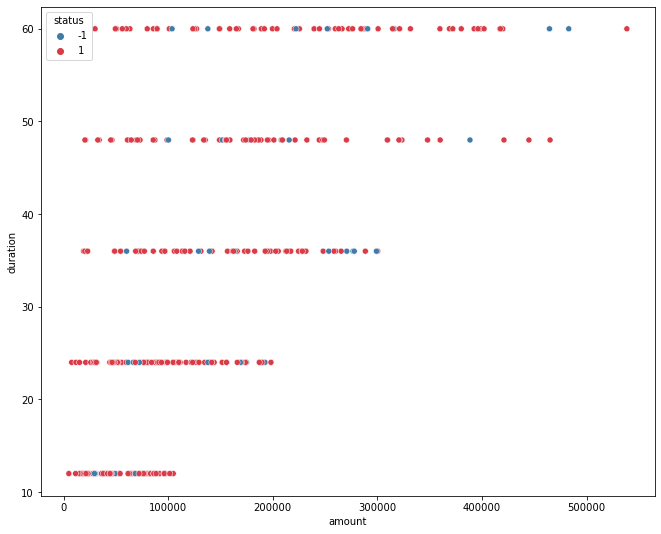

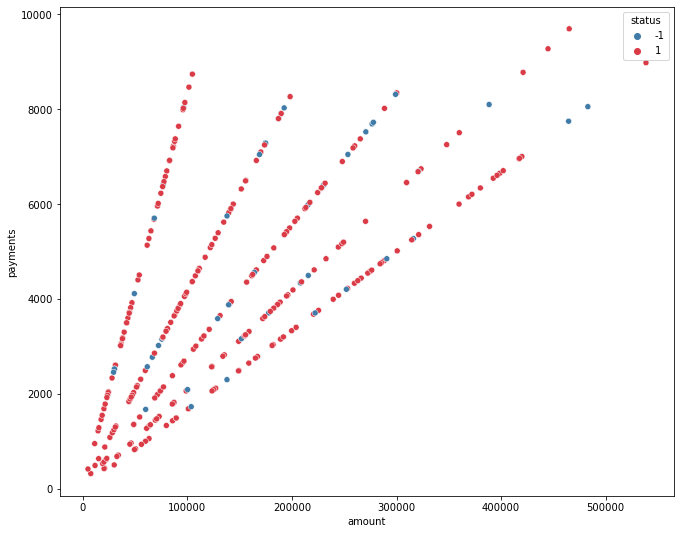

As expected, the larger the amount, the larger is the monthly payment or the duration.
Does the bank charge any interest rate?


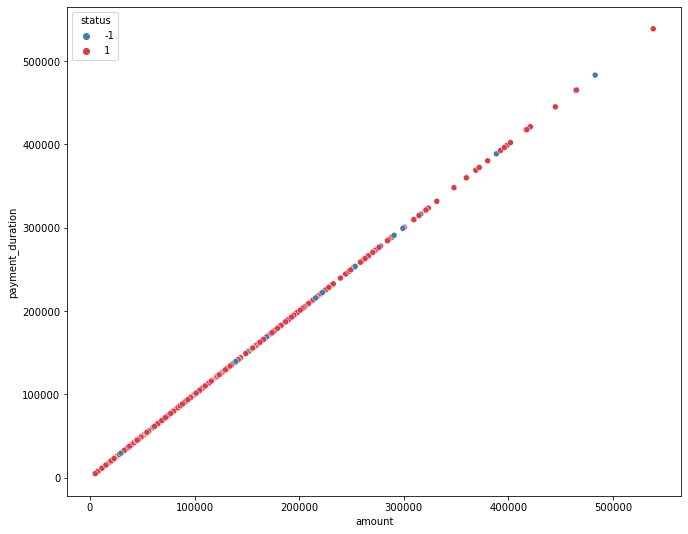

amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan


loan_id  account_id       date  amount  duration  payments  status
0       5314        1787 1993-07-05   96396        12      8033      -1
1       5316        1801 1993-07-11  165960        36      4610       1
2       6863        9188 1993-07-28  127080        60      2118       1
3       5325        1843 1993-08-03  105804        36      2939       1
4       7240       11013 1993-09-06  274740        60      4579       1
..       ...         ...        ...     ...       ...       ...     ...
323     6818        9030 1996-12-12  155616        48      3242       1
324     5625        3189 1996-12-15  222180        60      3703      -1
325     6805        8972 1996-12-21   45024        48       938       1
326     7233       10963 1996-12-25  115812        36      3217       1
327     7308       11362 1996-12-27  129408        24      5392       1

[328 rows x 7 columns]

In [20]:
def process_loans(loans_df, debug=False):
    
    if debug:
        print('Raw loans representation')
        display(loans_df)
        print('Raw loans correlations')
        get_df_correlation(loans_df)
        
    processed_df = convert_date(loans_df, 'date')
    
    if debug:
        print('No past history regarding loans.')
        print('There is an obvious and expected correlation between the duration, amount and payments columns.')
        scatter_plot_two_cols(processed_df, 'amount', 'duration')
        scatter_plot_two_cols(processed_df, 'amount', 'payments')
        print('As expected, the larger the amount, the larger is the monthly payment or the duration.')
        
        print('Does the bank charge any interest rate?')
        processed_df['payment_duration'] = processed_df['duration'] * processed_df['payments']
        scatter_plot_two_cols(processed_df, 'amount', 'payment_duration')

        processed_df = processed_df.drop(['payment_duration'], axis=1)
        
        print('amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan')
        
    return processed_df

process_loans(loan_df, True)

Raw accounts representation


account_id  district_id         frequency    date
0            576           55  monthly issuance  930101
1           3818           74  monthly issuance  930101
2            704           55  monthly issuance  930101
3           2378           16  monthly issuance  930101
4           2632           24  monthly issuance  930102
...          ...          ...               ...     ...
4495         124           55  monthly issuance  971228
4496        3958           59  monthly issuance  971228
4497         777           30  monthly issuance  971228
4498        1573           63  monthly issuance  971229
4499        3276            1  monthly issuance  971229

[4500 rows x 4 columns]

Raw accounts correlations


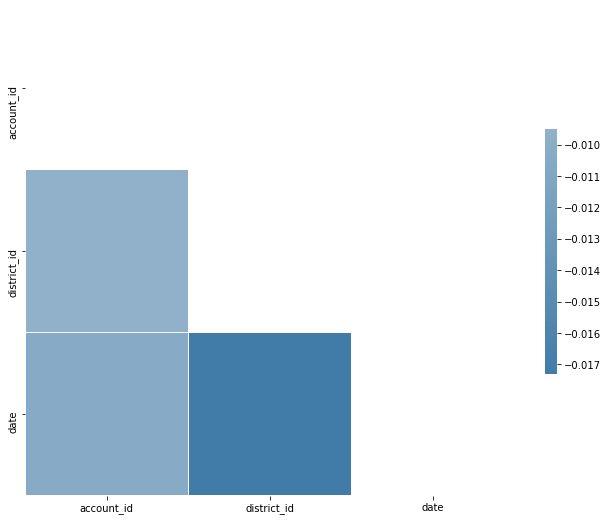

frequency column encoded:


account_id  district_id  frequency       date
0            576           55          1 1993-01-01
1           3818           74          1 1993-01-01
2            704           55          1 1993-01-01
3           2378           16          1 1993-01-01
4           2632           24          1 1993-01-02
...          ...          ...        ...        ...
4495         124           55          1 1997-12-28
4496        3958           59          1 1997-12-28
4497         777           30          1 1997-12-28
4498        1573           63          1 1997-12-29
4499        3276            1          1 1997-12-29

[4500 rows x 4 columns]

Features correlation:


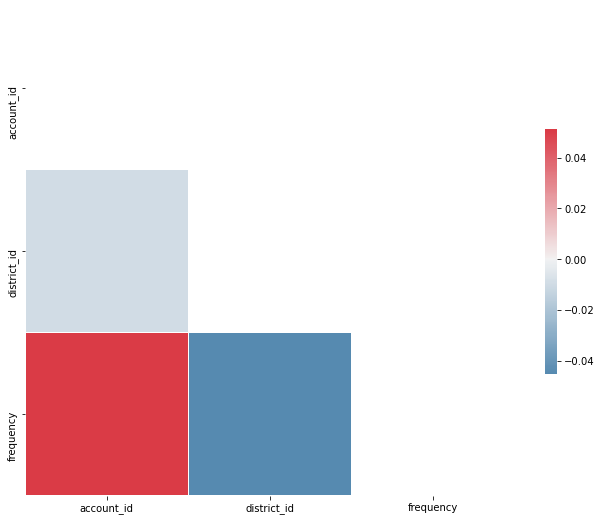

In [21]:
def process_account(accounts_df, debug=False):
    if debug:
        print('Raw accounts representation')
        display(accounts_df)
        print('Raw accounts correlations')
        get_df_correlation(accounts_df)
        
    processed_account = convert_date(account_df, 'date')
    
    # Encode categorical column
    df = encode_column(processed_account, 'frequency')
        
    if debug:
        print('frequency column encoded:')
        display(df)
        print('Features correlation:')
        get_df_correlation(df)

    return df

processed_account = process_account(account_df, True)

Raw disposition representation


disp_id  client_id  account_id       type
0           1          1           1      OWNER
1           2          2           2      OWNER
2           3          3           2  DISPONENT
3           4          4           3      OWNER
4           5          5           3  DISPONENT
...       ...        ...         ...        ...
5364    13647      13955       11349      OWNER
5365    13648      13956       11349  DISPONENT
5366    13660      13968       11359      OWNER
5367    13663      13971       11362      OWNER
5368    13690      13998       11382      OWNER

[5369 rows x 4 columns]

Raw disposition correlations


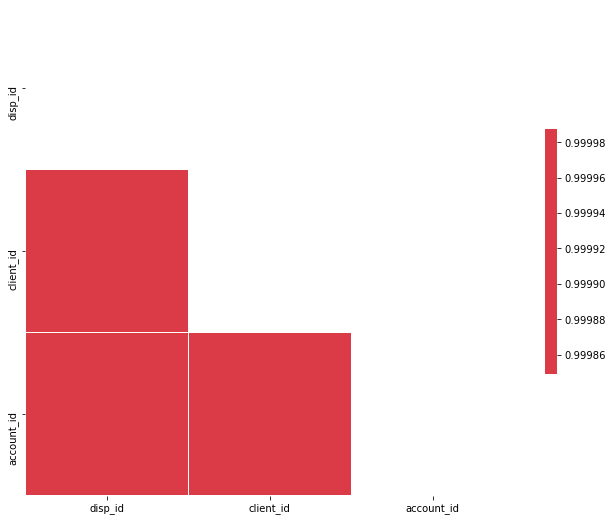

Transformed the categorical type column into numerical respective columns


disp_id  client_id  account_id  type_O  type_U
0           1          1           1       1       0
1           2          2           2       1       0
2           3          3           2       0       1
3           4          4           3       1       0
4           5          5           3       0       1
...       ...        ...         ...     ...     ...
5364    13647      13955       11349       1       0
5365    13648      13956       11349       0       1
5366    13660      13968       11359       1       0
5367    13663      13971       11362       1       0
5368    13690      13998       11382       1       0

[5369 rows x 5 columns]

Since the 2 categories are depedent, we can remove one of them, for removing redundant data


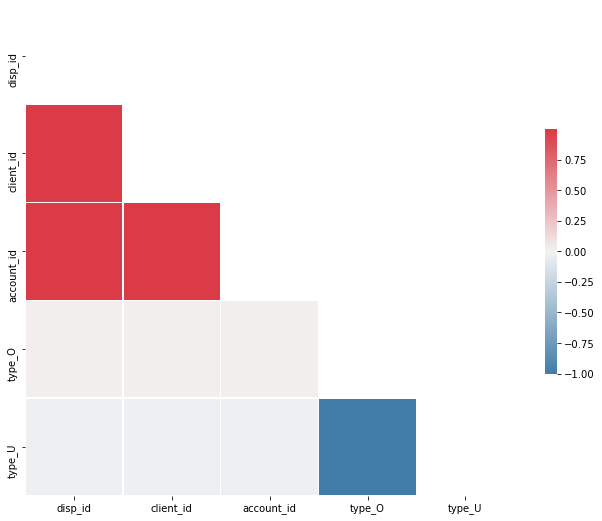

In [22]:
def process_dispostition(disp_df, debug=False):
    
    if debug:
        print('Raw disposition representation')
        display(disp_df)
        print('Raw disposition correlations')
        get_df_correlation(disp_df)
        
    processed_disp = disp_df.copy()
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"] == "OWNER",    "type"] = "O"
    processed_disp.loc[processed_disp["type"] == "DISPONENT","type"] = "U"
    
    # Transform numerical into categorical
    df = pd.get_dummies(processed_disp)
    
    if debug:
        print('Transformed the categorical type column into numerical respective columns')
        display(df)
        print('Since the 2 categories are depedent, we can remove one of them, for removing redundant data')
        get_df_correlation(df)
        
    # Cannot process further as needs merging with other columns
    return df

processed_disp = process_dispostition(disp_df, True)

Raw credit card representation


card_id  disp_id     type  issued
0       1005     9285  classic  931107
1        104      588  classic  940119
2        747     4915  classic  940205
3         70      439  classic  940208
4        577     3687  classic  940215
..       ...      ...      ...     ...
172      243     1478  classic  961213
173      162      967   junior  961223
174      594     3794   junior  961227
175      609     3893  classic  961229
176      786     5478  classic  961231

[177 rows x 4 columns]

Raw credit card correlations


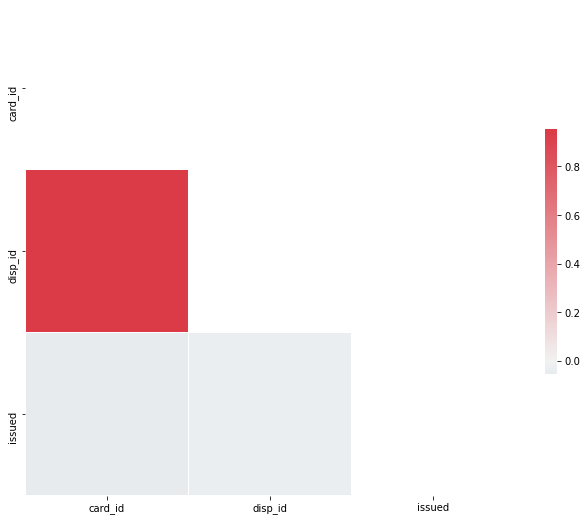

The distribution of type of cards per client:


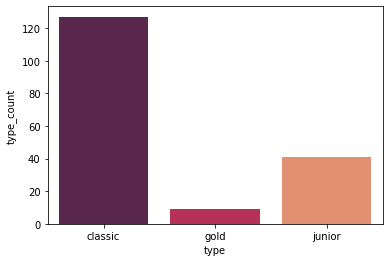

Encoded the type column:


disp_id  type     issued
0       9285     0 1993-11-07
1        588     0 1994-01-19
2       4915     0 1994-02-05
3        439     0 1994-02-08
4       3687     0 1994-02-15
..       ...   ...        ...
172     1478     0 1996-12-13
173      967     2 1996-12-23
174     3794     2 1996-12-27
175     3893     0 1996-12-29
176     5478     0 1996-12-31

[177 rows x 3 columns]

In [23]:
def process_card(card_df, debug=False):
    if debug:
        print('Raw credit card representation')
        display(card_df)
        print('Raw credit card correlations')
        get_df_correlation(card_df)

    processed_card = convert_date(card_df, 'issued')
    
    if debug:
        print('The distribution of type of cards per client:')
        bar_plot(processed_card, 'type')

    df = encode_column(processed_card, 'type')
    df = df.drop(['card_id'], axis=1)
    
    if debug:
        print('Encoded the type column:')
        display(df)
        
    # Cannot process further as needs merging with other columns
    return df

processed_card = process_card(card_df, True)

Raw client representation


client_id  birth_number  district_id
0             1        706213           18
1             2        450204            1
2             3        406009            1
3             4        561201            5
4             5        605703            5
...         ...           ...          ...
5364      13955        456030            1
5365      13956        430406            1
5366      13968        680413           61
5367      13971        626019           67
5368      13998        535812           74

[5369 rows x 3 columns]

Raw client correlations


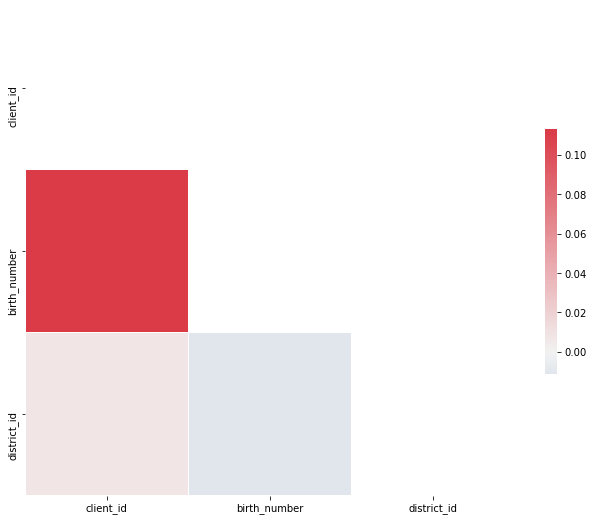

After extracting the gender from the date we have:


client_id  district_id  gender birth_date
0             1           18       1 1970-12-13
1             2            1       0 1945-02-04
2             3            1       1 1940-10-09
3             4            5       0 1956-12-01
4             5            5       1 1960-07-03
...         ...          ...     ...        ...
5364      13955            1       1 1945-10-30
5365      13956            1       0 1943-04-06
5366      13968           61       0 1968-04-13
5367      13971           67       1 1962-10-19
5368      13998           74       1 1953-08-12

[5369 rows x 4 columns]

Notice the gender representation:
	 * 1 if female
	 * 0 if male


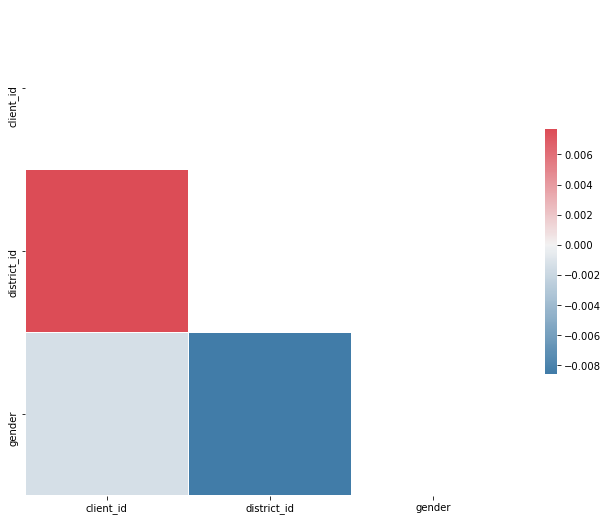

In [24]:
def process_client(client_df, debug=False):
    
    if debug:
        print('Raw client representation')
        display(client_df)
        print('Raw client correlations')
        get_df_correlation(client_df)
        
    processed_df = client_df.copy()
        
    # Getting year, day, and month+50 if women
    processed_df['year'] = 1900 + (processed_df['birth_number'] // 10000)
    processed_df['month_gender'] = (processed_df['birth_number'] % 10000) // 100
    processed_df['day'] = processed_df['birth_number'] % 100

    # Extracting gender and month
    processed_df['gender'] = np.where(processed_df['month_gender']>=50, 1, 0)
    processed_df['month'] = np.where(processed_df['month_gender']>=50, processed_df['month_gender']-50, processed_df['month_gender'])

    # Composing data
    processed_df['birth_date'] = processed_df['year'] * 10000 + processed_df['month'] * 100 + processed_df['day']
    df = convert_date(processed_df, 'birth_date', '%Y%m%d')
    
    # Dropping useless columns
    df = df.drop(['birth_number', 'year', 'month_gender', 'month', 'day'], axis=1)
    
    if debug:
        print('After extracting the gender from the date we have:')
        display(df)
        print('Notice the gender representation:\n\t * 1 if female\n\t * 0 if male')
        get_df_correlation(df)
    
    return df

processed_client = process_client(client_df, True)

Raw transactions table representation


trans_id  account_id    date        type  \
0        1548749        5270  930113      credit   
1        1548750        5270  930114      credit   
2        3393738       11265  930114      credit   
3        3122924       10364  930117      credit   
4        1121963        3834  930119      credit   
...          ...         ...     ...         ...   
396680    515914        1763  961231  withdrawal   
396681    516262        1765  961231  withdrawal   
396682    520019        1775  961231  withdrawal   
396683    517894        1769  961231  withdrawal   
396684    518239        1770  961231  withdrawal   

                           operation   amount  balance               k_symbol  \
0                     credit in cash    800.0    800.0                    NaN   
1       collection from another bank  44749.0  45549.0                    NaN   
2                     credit in cash   1000.0   1000.0                    NaN   
3                     credit in cash   1100.0   1100.0                    NaN   
4                     credit in cash    700.0    700.0                    NaN   
...                              ...      ...      ...                    ...   
396680            withdrawal in cash     14.6  67769.5  payment for statement   
396681            withdrawal in cash     14.6  19708.1  payment for statement   
396682            withdrawal in cash     14.6  15944.5  payment for statement   
396683            withdrawal in cash     14.6  34679.4  payment for statement   
396684            withdrawal in cash     14.6  68162.9  payment for statement   

       bank     account  
0       NaN         NaN  
1        IJ  80269753.0  
2       NaN         NaN  
3       NaN         NaN  
4       NaN         NaN  
...     ...         ...  
396680  NaN         NaN  
396681  NaN         NaN  
396682  NaN         NaN  
396683  NaN         NaN  
396684  NaN         NaN  

[396685 rows x 10 columns]

Raw transactions table correlations


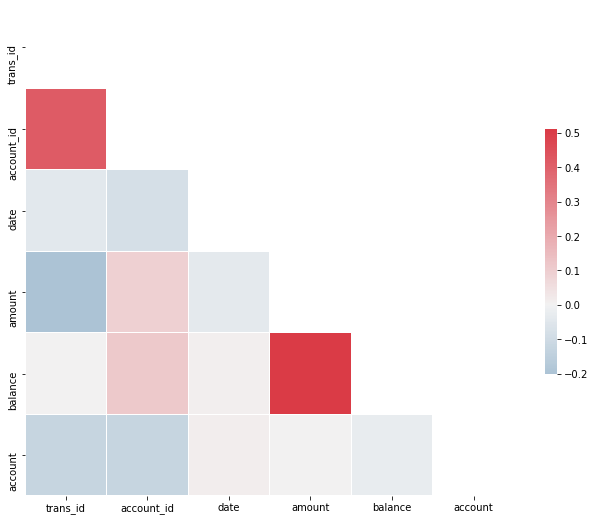

Null evaluation in transactions rows


trans_id      0.000000
account_id    0.000000
date          0.000000
type          0.000000
operation     0.178381
amount        0.000000
balance       0.000000
k_symbol      0.466980
bank          0.754863
account       0.742292
dtype: float64

Type of operations on Transactions:


array(['credit in cash', 'collection from another bank', nan,
       'withdrawal in cash', 'remittance to another bank',
       'credit card withdrawal'], dtype=object)

Type of k_symbol on Transactions:


array([' ', 'interest credited', 'household', 'payment for statement',
       'insurrance payment', 'sanction interest if negative balance',
       'old-age pension'], dtype=object)

Dataframe after renamings & deletion of empty columns


trans_id  account_id       date        type operation   amount  \
395175       175           1 1996-12-31  withdrawal        WC    -14.6   
396435   3530458           1 1996-12-31      credit        IC     59.2   
388524        99           1 1996-12-18  withdrawal        WC   -180.0   
386550        25           1 1996-12-13      credit       CAB   3679.0   
386552       219           1 1996-12-13  withdrawal        WC  -3700.0   
...          ...         ...        ...         ...       ...      ...   
202560   3459062       11382 1995-09-30      credit        IC     40.4   
204824   3530267       11382 1995-09-30      credit        IC     37.0   
200744   3431245       11382 1995-09-19  withdrawal        WC  -6800.0   
198263   3431070       11382 1995-09-10      credit       CAB  30832.0   
191796   3431061       11382 1995-08-20      credit        CC    200.0   

        balance               k_symbol  
395175  12659.9  payment for statement  
396435  12674.5      interest credited  
388524  12615.3                         
386550  16495.3                         
386552  12795.3                         
...         ...                    ...  
202560  24272.4      interest credited  
204824  24309.4      interest credited  
200744  24232.0                         
198263  31032.0                         
191796    200.0                         

[396685 rows x 8 columns]

array(['CC', 'CAB', 'IC', 'WC', 'RAB', 'CCW'], dtype=object)

 We can also compute the type operations for each account, and the respective statistics:


account_id  CC       CC_mean    CC_sum   CC_max        CC_std  CC_min  \
0              1   8   2600.000000   20800.0  12600.0   4120.679556   100.0   
1              2   2   2400.000000    4800.0   3700.0   1838.477631  1100.0   
2              4   1    800.000000     800.0    800.0      0.000000   800.0   
3              6   1    900.000000     900.0    900.0      0.000000   900.0   
4              7   2  17437.500000   34875.0  33975.0  23387.556788   900.0   
...          ...  ..           ...       ...      ...           ...     ...   
3365       11333  44  20410.295455  898053.0  48037.0  13729.385382   500.0   
3366       11349   2    250.000000     500.0    300.0     70.710678   200.0   
3367       11359   1   1000.000000    1000.0   1000.0      0.000000  1000.0   
3368       11362  16  15880.437500  254087.0  24212.0   6318.812124  1000.0   
3369       11382   1    200.000000     200.0    200.0      0.000000   200.0   

       CAB      CAB_mean   CAB_sum  CAB_max      CAB_std  CAB_min    IC  \
0     21.0   3679.000000   77259.0   3679.0     0.000000   3679.0  21.0   
1     10.0  22259.600000  222596.0  30354.0  4266.123382  20236.0  10.0   
2     10.0   5553.000000   55530.0   5553.0     0.000000   5553.0   6.0   
3     27.0   6669.000000  180063.0   6669.0     0.000000   6669.0  23.0   
4      0.0      0.000000       0.0      0.0     0.000000      0.0   1.0   
...    ...           ...       ...      ...          ...      ...   ...   
3365   0.0      0.000000       0.0      0.0     0.000000      0.0  57.0   
3366   5.0  46186.800000  230934.0  62982.0  9388.802224  41988.0   4.0   
3367  22.0  29469.818182  648336.0  40521.0  5332.172126  27014.0  22.0   
3368   0.0      0.000000       0.0      0.0     0.000000      0.0  13.0   
3369  16.0  33722.500000  539560.0  46248.0  6214.388272  30832.0  32.0   

         IC_mean  IC_sum  IC_max      IC_std  IC_min     WC       WC_mean  \
0      74.814286  1571.1   108.9   18.910798    19.2   47.0  -1015.706383   
1     128.930000  1289.3   203.0   49.413607    13.5   27.0  -6093.133333   
2      98.416667   590.5   110.0   16.204866    66.6   11.0  -1261.600000   
3     122.782609  2824.0   146.3   17.056261    70.3   50.0  -1186.716000   
4      30.400000    30.4    30.4    0.000000    30.4    1.0  -6600.000000   
...          ...     ...     ...         ...     ...    ...           ...   
3365  126.163158  7191.3   410.3   96.466859     1.1  107.0  -8275.402804   
3366  189.125000   756.5   262.6  102.905049    39.0    6.0 -32766.666667   
3367  163.472727  3596.4   258.1   48.589477    67.3   66.0  -8160.996970   
3368  111.846154  1454.0   165.7   36.008809    50.1   38.0  -4694.510526   
3369  108.956250  3486.6   215.3   49.492371    36.3   50.0 -10324.820000   

        WC_sum  WC_max        WC_std   WC_min   RAB      RAB_mean  RAB_sum  \
0     -47738.2   -14.6   1533.109438  -7500.0  16.0  -2452.000000 -39232.0   
1    -164514.6   -14.6   6547.076631 -22400.0   5.0  -7266.000000 -36330.0   
2     -13877.6   -14.6   1585.793139  -4100.0  11.0  -1645.454545 -18100.0   
3     -59335.8   -14.6   1950.114384 -11600.0  23.0  -3954.000000 -90942.0   
4      -6600.0 -6600.0      0.000000  -6600.0   0.0      0.000000      0.0   
...        ...     ...           ...      ...   ...           ...      ...   
3365 -885468.1    -0.1  10289.015899 -45300.0   0.0      0.000000      0.0   
3366 -196600.0 -8500.0  19789.458473 -64800.0   1.0 -10886.000000 -10886.0   
3367 -538625.8   -14.6   7980.973417 -30100.0  34.0  -2386.000000 -81124.0   
3368 -178391.4   -14.6   4235.460386 -16100.0  40.0  -1323.750000 -52950.0   
3369 -516241.0    -1.0  10117.912422 -36000.0   0.0      0.000000      0.0   

      RAB_max      RAB_std  RAB_min  CCW  CCW_mean  CCW_sum  CCW_max  \
0     -2452.0     0.000000  -2452.0  0.0       0.0      0.0      0.0   
1     -7266.0     0.000000  -7266.0  0.0       0.0      0.0      0.0   
2     -1285.0   414.130744  -2078.0  0.0       0.0      0.0      0.0   
3     

Table after processment of balance, credits, withdrawals, households, pensions and operations


account_id  balance_mean  balance_max  balance_min   balance_std  \
0              1  17558.700000      30414.8       1000.0   4168.729384   
1              2  32590.624074      67529.6       1100.0  12061.705682   
2              4  23648.623077      30623.5        800.0   5779.862046   
3              6  30313.279839      40391.5        900.0   5582.676041   
4              7  23088.850000      34875.0        900.0  15114.749329   
...          ...           ...          ...          ...           ...   
3365       11333  36827.658173     137043.2      -1291.0  29925.328077   
3366       11349  59352.833333     104039.9        200.0  27879.396857   
3367       11359  36480.185034      81705.8       1000.0  15469.988113   
3368       11362  30869.781308      56055.6       1000.0  11709.142375   
3369       11382  34805.087879      93550.2      -1036.7  21579.579905   

      last_balance  first_balance last_trans_date  last_trans  \
0          12659.9         1000.0      1996-12-31       -14.6   
1          27840.6         1100.0      1993-12-31       -14.6   
2          24943.0          800.0      1996-12-31       -14.6   
3          33509.2          900.0      1996-12-31       -14.6   
4          28305.4          900.0      1996-12-31        30.4   
...            ...            ...             ...         ...   
3365       19790.4          500.0      1996-12-31       142.8   
3366       24704.4          200.0      1995-10-23       300.0   
3367       25682.6         1000.0      1996-07-31       -14.6   
3368       24199.5         1000.0      1996-12-10     -4780.0   
3369       27005.4          200.0      1996-12-31       -14.6   

      reached_negative_balance   credit_mean  credit_count  credit_max  \
0                          1.0   1992.602000            50     12600.0   
1                          1.0  10394.786364            22     30354.0   
2                          1.0   3348.264706            17      5553.0   
3                          1.0   3603.666667            51      6669.0   
4                          1.0  11635.133333             3     33975.0   
...                        ...           ...           ...         ...   
3365                      -1.0   8962.814851           101     48037.0   
3366                       1.0  21108.227273            11     62982.0   
3367                       1.0  14509.608889            45     40521.0   
3368                       1.0   8811.758621            29     24212.0   
3369                      -1.0  11086.665306            49     46248.0   

      credit_min    credit_std  withdrawal_mean  withdrawal_count  \
0           19.2   2298.080022     -1380.479365              63.0   
1           13.5  11457.269613     -6276.393750              32.0   
2           66.6   2721.128176     -1453.527273              22.0   
3           70.3   3285.410780     -2058.600000              73.0   
4           30.4  19351.777258     -6600.000000               1.0   
...          ...           ...              ...               ...   
3365         1.1  13536.154328     -8275.402804             107.0   
3366        39.0  24734.340292    -29640.857143               7.0   
3367        67.3  15248.890444     -6149.507843             102.0   
3368        50.1   9224.068085     -2965.915385              78.0   
3369        36.3  16299.472136    -10324.820000              50.0   

      withdrawal_max  withdrawal_min  withdrawal_std  household  pension  \
0              -14.6         -7500.0     1463.225675    -2452.0      0.0   
1              -14.6        -22400.0     6011.475327    -7266.0      0.0   
2              -14.6         -4100.0     1147.934693    -2078.0   5553.0   
3              -14.6        -11600.0     2064.857715    -3954.0   6669.0   
4            -6600.0         -6600.0        0.000000        0.0      0.0   
...              ...             ...             ...        ...      ...   
3365            -0.1        -45300.0    10289.015899        0.0      0.0   
3366      

account_id      0.0
balance_mean    0.0
balance_max     0.0
balance_min     0.0
balance_std     0.0
               ... 
ratio_CAB       0.0
ratio_WC        0.0
ratio_RAB       0.0
ratio_CCW       0.0
ratio_IC        0.0
Length: 85, dtype: float64

And the corresponding correlation matrix


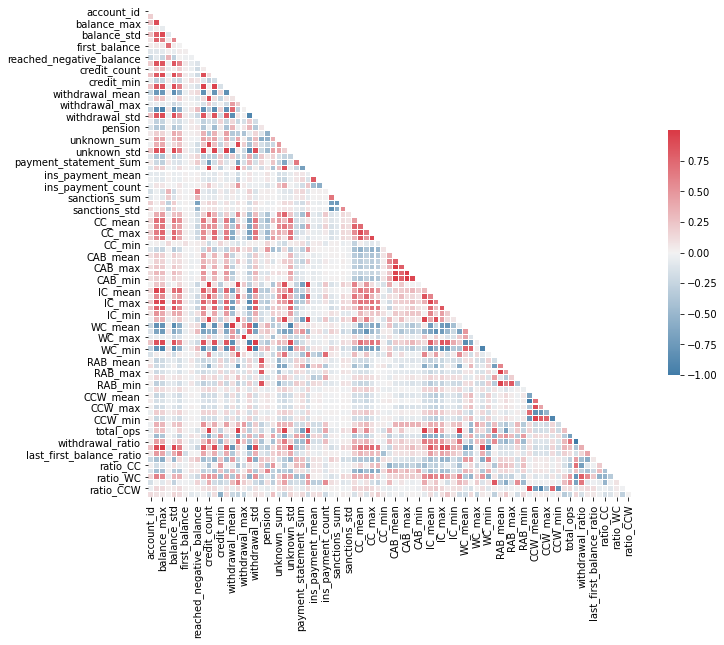

In [25]:
def process_transactions(transactions_df, debug=True):

    if debug:
        print('Raw transactions table representation')
        display(transactions_df)
        print('Raw transactions table correlations')
        get_df_correlation(transactions_df)
        print('Null evaluation in transactions rows')
        missing_values(transactions_df)
        
    # Removing the null columns & processing data
    processed_df = missing_values_cleaning(transactions_df)
    processed_df = convert_date(processed_df, 'date')
    
    # Filling null columns with too much nulls
    processed_df = clean_categorical_missing_values(processed_df, 'k_symbol', ' ')
    
    if debug:
        print('Type of operations on Transactions:')
        display(processed_df['operation'].unique())
        print('Type of k_symbol on Transactions:')
        display(processed_df['k_symbol'].unique())
    
    # Renaming 'withdrawal in cash' to 'withdrawal'
    processed_df.loc[processed_df["type"]=="withdrawal in cash","type"] = "withdrawal"

    # Renaming of operations
    processed_df.loc[processed_df["operation"]=="credit in cash", "operation"] = "CC"
    processed_df.loc[processed_df["operation"]=="collection from another bank", "operation"] = "CAB"
    processed_df.loc[processed_df["operation"]=="withdrawal in cash", "operation"] = "WC"
    processed_df.loc[processed_df["operation"]=="remittance to another bank", "operation"] = "RAB"
    processed_df.loc[processed_df["operation"]=="credit card withdrawal", "operation"] = "CCW"
    processed_df = clean_categorical_missing_values(processed_df, 'operation', 'IC') # Interest credited
    
    # Making withdrawals amount negatives
    processed_df.loc[processed_df["type"]=="withdrawal", "amount"] *=-1 
    
    if debug:
        print('Dataframe after renamings & deletion of empty columns')
        display(processed_df.sort_values(by=['account_id', 'date'],
                                         ascending=[True, False]))
        display(processed_df['operation'].unique())
    
    # Aggregatting transaction balances
    agg_ballance = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                               .groupby(['account_id'])\
                               .agg({
                                    'balance': ['mean', 'max', 'min', 'std', get_first, get_last],
                                    'date': get_first,
                                    'amount': get_first
                               }).reset_index()
    agg_ballance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std',
                            'last_balance', 'first_balance', 'last_trans_date', 'last_trans']
    agg_ballance['reached_negative_balance'] = agg_ballance['balance_min']
    agg_ballance.loc[agg_ballance["balance_min"] >= 0, "reached_negative_balance"] = 1
    agg_ballance.loc[agg_ballance["balance_min"] < 0, "reached_negative_balance"] = -1

    # Agrregatting credits &. withdrawals
    agg_types = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                              .groupby(['account_id', 'type'])\
                              .agg({
                                  'amount': ['mean', 'count', 'max', 'min', 'std'],
                              })\
                              .reset_index()
    agg_types.columns = ['account_id', 'type', 'type_mean', 'type_count',
                           'type_max', 'type_min', 'type_std']

    agg_credits = agg_types[agg_types['type'] == 'credit']
    agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count',
                           'credit_max', 'credit_min', 'credit_std']
    agg_credits.drop(['type'], axis=1)
    
    agg_withdrawals = agg_types[agg_types['type'] == 'withdrawal']
    agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count',
                           'withdrawal_max', 'withdrawal_min', 'withdrawal_std']
    agg_withdrawals.drop(['type'], axis=1)
    
    # Aggregatting k_symbols
    agg_k_symbol = processed_df.groupby(['account_id', 'k_symbol'])\
                           .agg({
                               'amount': ['mean', 'sum', 'count', 'std']
                           })\
                           .reset_index()
    agg_k_symbol.columns = ['account_id', 'k_symbol', 'amount_mean',
                            'amount_sum', 'amount_count', 'amount_std']

    
    # Geetting households - only mean is interesting
    households = agg_k_symbol[agg_k_symbol['k_symbol'] == 'household']
    households.columns = ['account_id', 'k_symbol', 'household', '_1', '_2', '_3']
    households = households.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    
    # Geetting pensions - only mean is interesting
    pensions = agg_k_symbol[agg_k_symbol['k_symbol'] == 'old-age pension']
    pensions.columns = ['account_id', 'k_symbol', 'pension', '_1', '_2', '_3']
    pensions = pensions.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    
    # Geetting unknown stats
    unknown = agg_k_symbol[agg_k_symbol['k_symbol'] == ' ']
    unknown.columns = ['account_id', 'k_symbol', 'unknown_mean', 'unknown_sum', 'unknown_count', 'unknown_std']
    unknown = unknown.drop(['k_symbol'], axis=1)

    # Gettting payments for statement stats
    payment_st = agg_k_symbol[agg_k_symbol['k_symbol'] == 'payment for statement']
    payment_st.columns = ['account_id', 'k_symbol', 'payment_statement_mean', 'payment_statement_sum',
                        'payment_statement_count', '_2']
    payment_st = payment_st.drop(['k_symbol', '_2'], axis=1)
    
    # Getting insurance payment stats
    ins_payment = agg_k_symbol[agg_k_symbol['k_symbol'] == 'insurrance payment']
    ins_payment.columns = ['account_id', 'k_symbol', 'ins_payment_mean', 'ins_payment_sum',
                        'ins_payment_count', '_2']
    ins_payment = ins_payment.drop(['k_symbol', '_2'], axis=1)
    
    # Getting saction payment stats
    sanctions = agg_k_symbol[agg_k_symbol['k_symbol'] == 'sanction interest if negative balance']
    sanctions.columns = ['account_id', 'k_symbol', 'sanctions_mean', 'sanctions_sum',
                        'sanctions_count', 'sanctions_std']
    sanctions = sanctions.drop(['k_symbol'], axis=1)

    # Aggregatting all the 5 tables into one - agg_ballance, agg_credits, agg_withdrawals, households & pensions
    df = agg_ballance.merge(agg_credits, on='account_id', how='left')\
                     .merge(agg_withdrawals, on='account_id', how='left')\
                     .merge(households, on='account_id', how='left')\
                     .merge(pensions, on='account_id', how='left')\
                     .merge(unknown, on='account_id', how='left')\
                     .merge(payment_st, on='account_id', how='left')\
                     .merge(ins_payment, on='account_id', how='left')\
                     .merge(sanctions, on='account_id', how='left')

    
    # Cleaning nulls
    df = df.drop(['type_x', 'type_y'], axis=1)
    df = clean_numerical_missing_values(df, 0)

    
    # Cleaning nulls and performing aggreggation on table containing operations
    operations = processed_df.groupby(['account_id', 'operation'])\
                             .agg({
                                 'amount': ['count', 'mean', 'sum', 'max', 'std', 'min'],
                             })\
                             .reset_index()
    operations.columns = ['account_id', 'operation', 'amount_count', 'amount_mean', 'amount_sum',
                          'amount_max', 'amount_std', 'amount_min']
    
    # Getting CC
    cc = operations[operations['operation'] == 'CC']
    cc.columns = ['account_id', 'operation', 'CC', 'CC_mean', 'CC_sum', 'CC_max', 'CC_std', 'CC_min']
    cc = cc.drop(['operation'], axis=1)
    
    # Getting CAB
    cab = operations[operations['operation'] == 'CAB']
    cab.columns = ['account_id', 'operation', 'CAB', 'CAB_mean', 'CAB_sum', 'CAB_max', 'CAB_std', 'CAB_min']
    cab =cab.drop(['operation'], axis=1)
    
    # Getting IC
    ic = operations[operations['operation'] == 'IC']
    ic.columns = ['account_id', 'operation', 'IC', 'IC_mean', 'IC_sum', 'IC_max', 'IC_std', 'IC_min']
    ic = ic.drop(['operation'], axis=1)
    
    # Getting WC
    wc = operations[operations['operation'] == 'WC']
    wc.columns = ['account_id', 'operation', 'WC', 'WC_mean', 'WC_sum', 'WC_max', 'WC_std', 'WC_min']
    wc = wc.drop(['operation'], axis=1)
    
    # Getting RAB
    rab = operations[operations['operation'] == 'RAB']
    rab.columns = ['account_id', 'operation', 'RAB', 'RAB_mean', 'RAB_sum', 'RAB_max', 'RAB_std', 'RAB_min']
    rab = rab.drop(['operation'], axis=1)
    
    # Getting CCW
    ccw = operations[operations['operation'] == 'CCW']
    ccw.columns = ['account_id', 'operation', 'CCW', 'CCW_mean', 'CCW_sum', 'CCW_max', 'CCW_std', 'CCW_min']
    ccw = ccw.drop(['operation'], axis=1)
    
    # Joining all the operations
    operations_df = cc.merge(cab, on='account_id', how='left')\
                      .merge(ic, on='account_id', how='left')\
                      .merge(wc, on='account_id', how='left')\
                      .merge(rab, on='account_id', how='left')\
                      .merge(ccw, on='account_id', how='left')
    # Cleaning nulls
    operations_df = clean_numerical_missing_values(operations_df, 0)
    
    if debug:
        print(' We can also compute the type operations for each account, and the respective statistics:')
        display(operations_df)
        
    # Join operations with the numeric data
    df = df.merge(operations_df, on='account_id', how='left')
    
    # Adding extra columns
    df['mean_trans_profit'] = df['credit_mean'] + df['withdrawal_mean']
    df['total_ops'] = df['CC'] + df['CAB'] + df['WC'] + df['RAB'] + df['CCW'] + df['IC']
    df['credit_ratio'] = df['credit_count'] / df['total_ops']
    df['withdrawal_ratio'] = df['withdrawal_count'] / df['total_ops']
    df['balance_range'] = df['balance_max'] - df['balance_min']
    df['last_first_balance_ratio'] = df['last_balance'] / df['first_balance']
    df['last_max_balance_ratio'] = df['last_balance'] / df['balance_max']

    # OPs as ratios
    df['ratio_CC']  = df['CC']  / df['total_ops']
    df['ratio_CAB'] = df['CAB'] / df['total_ops']
    df['ratio_WC']  = df['WC']  / df['total_ops']
    df['ratio_RAB'] = df['RAB'] / df['total_ops']
    df['ratio_CCW'] = df['CCW'] / df['total_ops']
    df['ratio_IC']  = df['IC']  / df['total_ops']

    # df = df.drop(['CC', 'CAB', 'WC', 'RAB', 'CCW', 'IC', 'credit_count', 'withdrawal_count'], axis=1)

    if debug:
        print('Table after processment of balance, credits, withdrawals, households, pensions and operations')
        display(df)
        missing_values(df)
        print('And the corresponding correlation matrix')
        get_df_correlation(df)
    
    return df

processed_trans = process_transactions(trans_df, True)

 > Raw demographic table representation


code             name            region  no. of inhabitants  \
0       1      Hl.m. Praha           Prague             1204953   
1       2          Benesov  central Bohemia               88884   
2       3           Beroun  central Bohemia               75232   
3       4           Kladno  central Bohemia              149893   
4       5            Kolin  central Bohemia               95616   
..    ...              ...              ...                 ...   
72     73            Opava    north Moravia              182027   
73     74  Ostrava - mesto    north Moravia              323870   
74     75           Prerov    north Moravia              138032   
75     76          Sumperk    north Moravia              127369   
76     77           Vsetin    north Moravia              148545   

    no. of municipalities with inhabitants < 499   \
0                                               0   
1                                              80   
2                                              55   
3                                              63   
4                                              65   
..                                            ...   
72                                             17   
73                                              0   
74                                             67   
75                                             31   
76                                              8   

    no. of municipalities with inhabitants 500-1999  \
0                                                 0   
1                                                26   
2                                                26   
3                                                29   
4                                                30   
..                                              ...   
72                                               49   
73                                                0   
74                                               30   
75                                               32   
76                                               35   

    no. of municipalities with inhabitants 2000-9999   \
0                                                   0   
1                                                   6   
2                                                   4   
3                                                   6   
4                                                   4   
..                                                ...   
72                                                 12   
73                                                  0   
74                                                  4   
75                                                 13   
76                                                 12   

    no. of municipalities with inhabitants >10000   no. of cities   \
0                                                1               1   
1                                                2               5   
2                                                1               5   
3                                                2               6   
4                                                1               6   
..                                             ...             ...   
72                                               2               7   
73                                               1               1   
74                                               2               5   
75                                               2               7   
76                                               3               4   

    ratio of urban inhabitants   average salary  unemploymant rate '95   \
0                         100.0            12541                   0.29   
1                          46.7             8507                   1.67   
2                          41.7             8980                   1.95   
3                          67.4             9753                   4.64   


 > Raw demographic table correlations


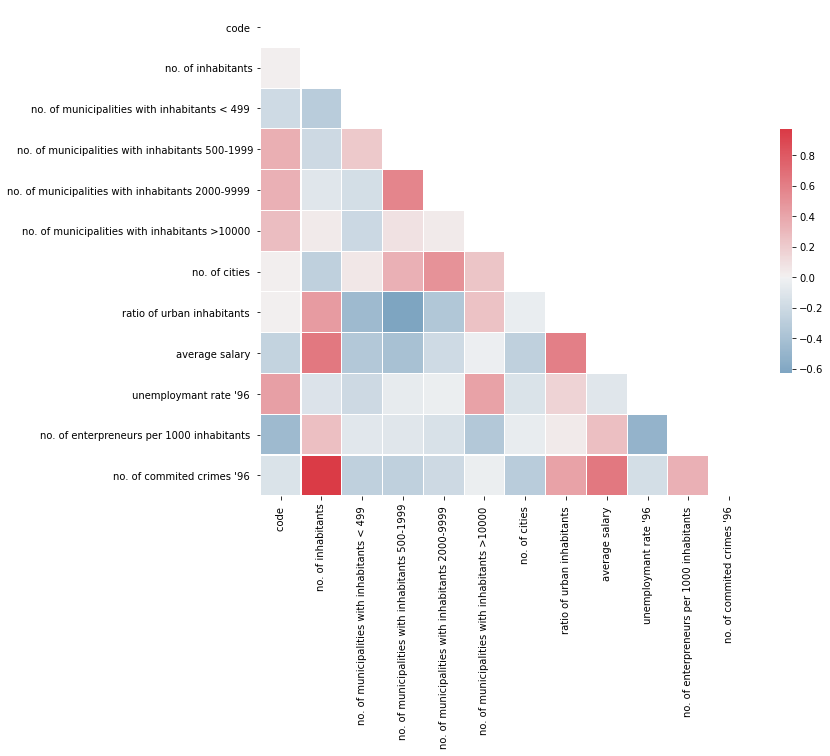

 > Null evaluation in demographic rows


code                                                 0.0
name                                                 0.0
region                                               0.0
no. of inhabitants                                   0.0
no. of municipalities with inhabitants < 499         0.0
no. of municipalities with inhabitants 500-1999      0.0
no. of municipalities with inhabitants 2000-9999     0.0
no. of municipalities with inhabitants >10000        0.0
no. of cities                                        0.0
ratio of urban inhabitants                           0.0
average salary                                       0.0
unemploymant rate '95                                0.0
unemploymant rate '96                                0.0
no. of enterpreneurs per 1000 inhabitants            0.0
no. of commited crimes '95                           0.0
no. of commited crimes '96                           0.0
dtype: float64

 > Lets see the impact of urbanization on salaries


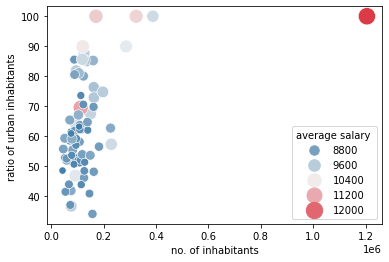

First, lets start by encoding the categorical columns


code   name   region  no. of inhabitants  \
0       1     17       0             1204953   
1       2      0       1               88884   
2       3      1       1               75232   
3       4     27       1              149893   
4       5     29       1               95616   
..    ...    ...     ...                 ...   
72     73     42       4              182027   
73     74     43       4              323870   
74     75     53       4              138032   
75     76     62       4              127369   
76     77     72       4              148545   

    no. of municipalities with inhabitants < 499   \
0                                               0   
1                                              80   
2                                              55   
3                                              63   
4                                              65   
..                                            ...   
72                                             17   
73                                              0   
74                                             67   
75                                             31   
76                                              8   

    no. of municipalities with inhabitants 500-1999  \
0                                                 0   
1                                                26   
2                                                26   
3                                                29   
4                                                30   
..                                              ...   
72                                               49   
73                                                0   
74                                               30   
75                                               32   
76                                               35   

    no. of municipalities with inhabitants 2000-9999   \
0                                                   0   
1                                                   6   
2                                                   4   
3                                                   6   
4                                                   4   
..                                                ...   
72                                                 12   
73                                                  0   
74                                                  4   
75                                                 13   
76                                                 12   

    no. of municipalities with inhabitants >10000   no. of cities   \
0                                                1               1   
1                                                2               5   
2                                                1               5   
3                                                2               6   
4                                                1               6   
..                                             ...             ...   
72                                               2               7   
73                                               1               1   
74                                               2               5   
75                                               2               7   
76                                               3               4   

    ratio of urban inhabitants   average salary  unemploymant rate '95   \
0                         100.0            12541                   0.29   
1                          46.7             8507                   1.67   
2                          41.7             8980                   1.95   
3                          67.4             9753                   4.64   
4                          51.4             9307                   3.85   
..                          ...              ...                    ...   
72                         56.4             8746                   3.33   
73 

Index(['code ', 'name ', 'region', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 '],
      dtype='object')

The final demographic plot, with additional features and having converted some features to ratios:


code   name   region  no. of inhabitants  \
0       1     17       0             1204953   
1       2      0       1               88884   
2       3      1       1               75232   
3       4     27       1              149893   
4       5     29       1               95616   
..    ...    ...     ...                 ...   
72     73     42       4              182027   
73     74     43       4              323870   
74     75     53       4              138032   
75     76     62       4              127369   
76     77     72       4              148545   

    no. of municipalities with inhabitants < 499   \
0                                               0   
1                                              80   
2                                              55   
3                                              63   
4                                              65   
..                                            ...   
72                                             17   
73                                              0   
74                                             67   
75                                             31   
76                                              8   

    no. of municipalities with inhabitants 500-1999  \
0                                                 0   
1                                                26   
2                                                26   
3                                                29   
4                                                30   
..                                              ...   
72                                               49   
73                                                0   
74                                               30   
75                                               32   
76                                               35   

    no. of municipalities with inhabitants 2000-9999   \
0                                                   0   
1                                                   6   
2                                                   4   
3                                                   6   
4                                                   4   
..                                                ...   
72                                                 12   
73                                                  0   
74                                                  4   
75                                                 13   
76                                                 12   

    no. of municipalities with inhabitants >10000   no. of cities   \
0                                                1               1   
1                                                2               5   
2                                                1               5   
3                                                2               6   
4                                                1               6   
..                                             ...             ...   
72                                               2               7   
73                                               1               1   
74                                               2               5   
75                                               2               7   
76                                               3               4   

    ratio of urban inhabitants   average salary   ratio entrepeneurs  \
0                         1.000            12541               0.167   
1                         0.467             8507               0.132   
2                         0.417             8980               0.111   
3                         0.674             9753               0.109   
4                         0.514             9307               0.118   
..                          ...              ...                 ...   
72                        0.564             8746               0.090   
73                        1

And the corresponding correlation matrix:


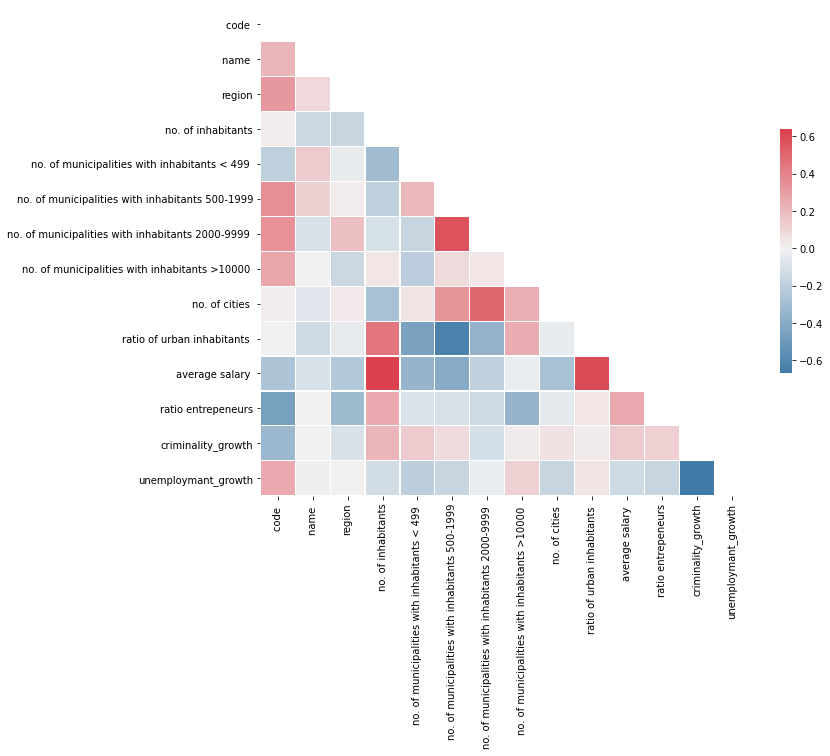

In [26]:
def process_demographic(demographic_df, debug=False):
    '''Pre process the demographic table'''
    if debug:
        print(' > Raw demographic table representation')
        display(demographic_df)
        print(' > Raw demographic table correlations')
        get_df_correlation(demographic_df)
        
    if debug:
        print(' > Null evaluation in demographic rows')
        missing_values(demographic_df)
        
    if debug:
        print(' > Lets see the impact of urbanization on salaries')
        bubble_plot_three_cols(demographic_df, 'no. of inhabitants',
                              'ratio of urban inhabitants ', 'average salary ')
    
    # Encode categorical columns
    df = encode_column(demographic_df, 'name ')
    df = encode_column(df, 'region')
    
    if debug:
        print('First, lets start by encoding the categorical columns')
        display(df)
        display(df.columns)

    # Replacing '?' by the average value
    median_crimes_95 = pd.to_numeric(df[df['no. of commited crimes \'95 '] != '?']\
                                     ['no. of commited crimes \'95 ']).median()
    df.loc[df['no. of commited crimes \'95 ']=="?", 'no. of commited crimes \'95 '] = median_crimes_95

    median_unemploymant_95 = (df[df['unemploymant rate \'95 '] != '?']\
                              ['unemploymant rate \'95 ']).astype(float).median()
    df.loc[df['unemploymant rate \'95 ']=="?", 'unemploymant rate \'95 '] = median_unemploymant_95
    
    # Transforming data to ints/ floats
    df['unemploymant rate \'95 '] = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '].astype(float)

    # Now lets create new features:
    df['ratio entrepeneurs'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    
    # Growths
    df['criminality_growth'] = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) /\
                              df['no. of inhabitants']
    df['unemploymant_growth'] = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']
    
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 
                 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ',
                  'unemploymant rate \'95 ', 'no. of commited crimes \'95 '], axis=1)
    
    if debug:
        print('The final demographic plot, with additional features and having converted some features to ratios:')
        display(df)
        print('And the corresponding correlation matrix:')
        get_df_correlation(df)

    return df.rename(columns={'code ': 'district_id'}).drop(['name '], axis=1)

processed_demogra = process_demographic(demogra_df, True)

# Composite pre processment of tables

 > Joint table of loans, account, transaction:


loan_id  account_id       date  amount  duration  payments  status  \
0       5314        1787 1993-07-05   96396        12      8033      -1   
1       5316        1801 1993-07-11  165960        36      4610       1   
2       6863        9188 1993-07-28  127080        60      2118       1   
3       5325        1843 1993-08-03  105804        36      2939       1   
4       7240       11013 1993-09-06  274740        60      4579       1   
..       ...         ...        ...     ...       ...       ...     ...   
323     6818        9030 1996-12-12  155616        48      3242       1   
324     5625        3189 1996-12-15  222180        60      3703      -1   
325     6805        8972 1996-12-21   45024        48       938       1   
326     7233       10963 1996-12-25  115812        36      3217       1   
327     7308       11362 1996-12-27  129408        24      5392       1   

     frequency account_creation_date  balance_mean  balance_max  balance_min  \
0            2            1993-03-22  12250.000000      20100.0       1100.0   
1            1            1993-02-13  52083.859459     120512.8        700.0   
2            1            1993-02-08  30060.954167      49590.4        800.0   
3            1            1993-01-30  41297.480000      65898.5       1000.0   
4            2            1993-02-14  57188.211111     122893.1        600.0   
..         ...                   ...           ...          ...          ...   
323          1            1995-01-21  44197.509884      75294.1        200.0   
324          1            1995-11-29  55230.444068     130659.1        800.0   
325          1            1996-05-21  41994.907692      63659.3        800.0   
326          1            1995-05-20  56646.516129     119527.2       1100.0   
327          1            1995-10-14  30869.781308      56055.6       1000.0   

      balance_std  last_balance  first_balance last_trans_date  last_trans  \
0     8330.866301       20100.0         1100.0      1993-06-20      3300.0   
1    29122.059454       52208.9          700.0      1993-07-09     -3419.0   
2    11520.184451       20272.8          800.0      1993-07-21    -12000.0   
3    14151.260443       34307.3         1000.0      1993-07-31       178.1   
4    25256.665817       41112.9          600.0      1993-08-31       -30.0   
..            ...           ...            ...             ...         ...   
323  11044.494392       60694.1          200.0      1996-12-11    -14600.0   
324  26510.559286       59578.8          800.0      1996-12-10     -6900.0   
325  13151.510254       38384.3          800.0      1996-12-17    -17800.0   
326  21971.162852       41878.1         1100.0      1996-12-18     -3100.0   
327  11709.142375       24199.5         1000.0      1996-12-10     -4780.0   

     reached_negative_balance   credit_mean  credit_count  credit_max  \
0                         1.0   5025.000000             4      9900.0   
1                         1.0  13523.158824            17     36574.0   
2                         1.0   5009.733333            15     19065.0   
3                         1.0   9254.600000            13     26448.0   
4                         1.0  21255.930769            13     63366.0   
..                        ...           ...           ...         ...   
323                       1.0   6448.582857            70     26388.0   
324                       1.0  13417.557143            28     44352.0   
325                       1.0   8544.930000            20     31636.5   
326                       1.0  16554.986275            51     49887.0   
327                       1.0   8811.758621            29     24212.0   

     credit_min    credit_std  withdrawal_mean  withdrawal_count  \
0        1100.0   3774.806838         0.000000               0.0   
1           2.9  13998.092225     -8884.240000              20.0   
2          48.6   6801.234716     -6097.000000               9.0   
3         132.8   9818.591218     -7168.100000           

 > Joint table of disposition, client & card:


disp_id  client_id  account_id  type_O  type_U  district_id  gender  \
0           1          1           1       1       0           18       1   
1           2          2           2       1       0            1       0   
2           3          3           2       0       1            1       1   
3           4          4           3       1       0            5       0   
4           5          5           3       0       1            5       1   
...       ...        ...         ...     ...     ...          ...     ...   
5364    13647      13955       11349       1       0            1       1   
5365    13648      13956       11349       0       1            1       0   
5366    13660      13968       11359       1       0           61       0   
5367    13663      13971       11362       1       0           67       1   
5368    13690      13998       11382       1       0           74       1   

     birth_date  type     issued  
0    1970-12-13   NaN        NaT  
1    1945-02-04   NaN        NaT  
2    1940-10-09   NaN        NaT  
3    1956-12-01   NaN        NaT  
4    1960-07-03   NaN        NaT  
...         ...   ...        ...  
5364 1945-10-30   NaN        NaT  
5365 1943-04-06   NaN        NaT  
5366 1968-04-13   0.0 1995-06-13  
5367 1962-10-19   NaN        NaT  
5368 1953-08-12   NaN        NaT  

[5369 rows x 10 columns]

disp_id        0.000000
client_id      0.000000
account_id     0.000000
type_O         0.000000
type_U         0.000000
district_id    0.000000
gender         0.000000
birth_date     0.000000
type           0.967033
issued         0.967033
dtype: float64

 > Table after aggreggating data by account_id:


account_id  owner_count  disponent_count  owner_gender owner_birthdate  \
0              1            1                1             1      1970-12-13   
1              2            2                2             0      1945-02-04   
2              3            2                2             0      1956-12-01   
3              4            1                1             0      1919-09-22   
4              5            1                1             0      1929-01-25   
...          ...          ...              ...           ...             ...   
4495       11333            1                1             0      1942-01-01   
4496       11349            2                2             1      1945-10-30   
4497       11359            1                1             0      1968-04-13   
4498       11362            1                1             1      1962-10-19   
4499       11382            1                1             1      1953-08-12   

      district_id  card_type  has_card  
0              18       -1.0      -1.0  
1               1       -1.0      -1.0  
2               5       -1.0      -1.0  
3              12       -1.0      -1.0  
4              15       -1.0      -1.0  
...           ...        ...       ...  
4495            8       -1.0      -1.0  
4496            1       -1.0      -1.0  
4497           61        0.0      -1.0  
4498           67       -1.0      -1.0  
4499           74       -1.0      -1.0  

[4500 rows x 8 columns]

 > Table after joining with the demographics table:


account_id  owner_count  disponent_count  owner_gender owner_birthdate  \
0              1            1                1             1      1970-12-13   
1            343            1                1             0      1978-03-13   
2            413            1                1             1      1935-07-08   
3            431            1                1             0      1980-04-13   
4            568            1                1             0      1979-10-21   
...          ...          ...              ...           ...             ...   
4495        7990            1                1             1      1967-03-17   
4496        8039            1                1             0      1972-06-23   
4497        8153            1                1             0      1974-04-23   
4498        9153            2                2             0      1938-09-25   
4499        9504            1                1             0      1949-04-14   

      district_id  card_type  has_card  region  no. of inhabitants  \
0              18       -1.0      -1.0       5               70699   
1              18       -1.0      -1.0       5               70699   
2              18       -1.0      -1.0       5               70699   
3              18       -1.0      -1.0       5               70699   
4              18       -1.0      -1.0       5               70699   
...           ...        ...       ...     ...                 ...   
4495            9       -1.0      -1.0       1               81344   
4496            9       -1.0      -1.0       1               81344   
4497            9       -1.0      -1.0       1               81344   
4498            9       -1.0      -1.0       1               81344   
4499            9       -1.0      -1.0       1               81344   

      no. of municipalities with inhabitants < 499   \
0                                                60   
1                                                60   
2                                                60   
3                                                60   
4                                                60   
...                                             ...   
4495                                             61   
4496                                             61   
4497                                             61   
4498                                             61   
4499                                             61   

      no. of municipalities with inhabitants 500-1999  \
0                                                  13   
1                                                  13   
2                                                  13   
3                                                  13   
4                                                  13   
...                                               ...   
4495                                               23   
4496                                               23   
4497                                               23   
4498                                               23   
4499                                               23   

      no. of municipalities with inhabitants 2000-9999   \
0                                                     2   
1                                                     2   
2                                                     2   
3                                                     2   
4                                                     2   
...                                                 ...   
4495                                                  4   
4496                                                  4   
4497                                                  4   
4498                                                  4   
4499                                                  4   

      no. of municipalities with inhabitants >10000   no. of cities   \
0                                                  1               4   
1    

 > Obtained dataframe after joining the previous tables and doing some feature engineering over them


loan_id       date  amount  duration  payments  status  frequency  \
0       5314 1993-07-05   96396        12      8033      -1          2   
1       5316 1993-07-11  165960        36      4610       1          1   
2       6863 1993-07-28  127080        60      2118       1          1   
3       5325 1993-08-03  105804        36      2939       1          1   
4       7240 1993-09-06  274740        60      4579       1          2   
..       ...        ...     ...       ...       ...     ...        ...   
323     6818 1996-12-12  155616        48      3242       1          1   
324     5625 1996-12-15  222180        60      3703      -1          1   
325     6805 1996-12-21   45024        48       938       1          1   
326     7233 1996-12-25  115812        36      3217       1          1   
327     7308 1996-12-27  129408        24      5392       1          1   

     balance_mean  balance_max  balance_min   balance_std  last_balance  \
0    12250.000000      20100.0       1100.0   8330.866301       20100.0   
1    52083.859459     120512.8        700.0  29122.059454       52208.9   
2    30060.954167      49590.4        800.0  11520.184451       20272.8   
3    41297.480000      65898.5       1000.0  14151.260443       34307.3   
4    57188.211111     122893.1        600.0  25256.665817       41112.9   
..            ...          ...          ...           ...           ...   
323  44197.509884      75294.1        200.0  11044.494392       60694.1   
324  55230.444068     130659.1        800.0  26510.559286       59578.8   
325  41994.907692      63659.3        800.0  13151.510254       38384.3   
326  56646.516129     119527.2       1100.0  21971.162852       41878.1   
327  30869.781308      56055.6       1000.0  11709.142375       24199.5   

     first_balance  last_trans  reached_negative_balance   credit_mean  \
0           1100.0      3300.0                       1.0   5025.000000   
1            700.0     -3419.0                       1.0  13523.158824   
2            800.0    -12000.0                       1.0   5009.733333   
3           1000.0       178.1                       1.0   9254.600000   
4            600.0       -30.0                       1.0  21255.930769   
..             ...         ...                       ...           ...   
323          200.0    -14600.0                       1.0   6448.582857   
324          800.0     -6900.0                       1.0  13417.557143   
325          800.0    -17800.0                       1.0   8544.930000   
326         1100.0     -3100.0                       1.0  16554.986275   
327         1000.0     -4780.0                       1.0   8811.758621   

     credit_count  credit_max  credit_min    credit_std  withdrawal_mean  \
0               4      9900.0      1100.0   3774.806838         0.000000   
1              17     36574.0         2.9  13998.092225     -8884.240000   
2              15     19065.0        48.6   6801.234716     -6097.000000   
3              13     26448.0       132.8   9818.591218     -7168.100000   
4              13     63366.0        77.1  24264.229780    -16801.000000   
..            ...         ...         ...           ...              ...   
323            70     26388.0        23.7   9143.297044     -3830.458824   
324            28     44352.0       103.2  15547.006686    -10197.180645   
325            20     31636.5        41.0  12066.488804     -6974.431579   
326            51     49887.0        51.1  17170.849461    -10992.139726   
327            29     24212.0        50.1   9224.068085     -2965.915385   

     withdrawal_count  withdrawal_max  withdrawal_min  withdrawal_std  \
0                 0.0             0.0             0.0        0.000000   
1                20.0           -14.6        -54300.0    14074.800608   
2                 9.0           -66.0        -14800.0     5390.565972   
3                12.0           -14.6        -15600.0     4919.096434   
4                14.0           -30.0        -36

 > And the respective correlations
 >>> Final table that will serve as input to the model:


loan_id  amount  duration  payments  frequency  balance_mean  \
0       5314   96396        12      8033          2  12250.000000   
1       5316  165960        36      4610          1  52083.859459   
2       6863  127080        60      2118          1  30060.954167   
3       5325  105804        36      2939          1  41297.480000   
4       7240  274740        60      4579          2  57188.211111   
..       ...     ...       ...       ...        ...           ...   
323     6818  155616        48      3242          1  44197.509884   
324     5625  222180        60      3703          1  55230.444068   
325     6805   45024        48       938          1  41994.907692   
326     7233  115812        36      3217          1  56646.516129   
327     7308  129408        24      5392          1  30869.781308   

     balance_max  balance_min   balance_std  last_balance  last_trans  \
0        20100.0       1100.0   8330.866301       20100.0      3300.0   
1       120512.8        700.0  29122.059454       52208.9     -3419.0   
2        49590.4        800.0  11520.184451       20272.8    -12000.0   
3        65898.5       1000.0  14151.260443       34307.3       178.1   
4       122893.1        600.0  25256.665817       41112.9       -30.0   
..           ...          ...           ...           ...         ...   
323      75294.1        200.0  11044.494392       60694.1    -14600.0   
324     130659.1        800.0  26510.559286       59578.8     -6900.0   
325      63659.3        800.0  13151.510254       38384.3    -17800.0   
326     119527.2       1100.0  21971.162852       41878.1     -3100.0   
327      56055.6       1000.0  11709.142375       24199.5     -4780.0   

     reached_negative_balance   credit_mean  credit_count  credit_max  \
0                         1.0   5025.000000             4      9900.0   
1                         1.0  13523.158824            17     36574.0   
2                         1.0   5009.733333            15     19065.0   
3                         1.0   9254.600000            13     26448.0   
4                         1.0  21255.930769            13     63366.0   
..                        ...           ...           ...         ...   
323                       1.0   6448.582857            70     26388.0   
324                       1.0  13417.557143            28     44352.0   
325                       1.0   8544.930000            20     31636.5   
326                       1.0  16554.986275            51     49887.0   
327                       1.0   8811.758621            29     24212.0   

     credit_min  withdrawal_mean  withdrawal_count  withdrawal_max  \
0        1100.0         0.000000               0.0             0.0   
1           2.9     -8884.240000              20.0           -14.6   
2          48.6     -6097.000000               9.0           -66.0   
3         132.8     -7168.100000              12.0           -14.6   
4          77.1    -16801.000000              14.0           -30.0   
..          ...              ...               ...             ...   
323        23.7     -3830.458824             102.0           -14.6   
324       103.2    -10197.180645              31.0           -14.6   
325        41.0     -6974.431579              19.0           -14.6   
326        51.1    -10992.139726              73.0           -14.6   
327        50.1     -2965.915385              78.0           -14.6   

     withdrawal_min  withdrawal_std  unknown_mean  unknown_sum   unknown_std  \
0               0.0        0.000000   5025.000000      20100.0   3774.806838   
1          -54300.0    14074.800608   2608.833333      62612.0  22249.103350   
2          -14800.0     5390.565972   1966.714286      27534.0  10647.755108   
3          -15600.0     4919.096434   2969.250000      47508.0  13937.959427   
4          -36700.0    13981.924936   2266.000000      40788.0  33727.841554   
..              ...             ...           ...          ...           ...   
323        -36960.0  

 > And the respective correlations


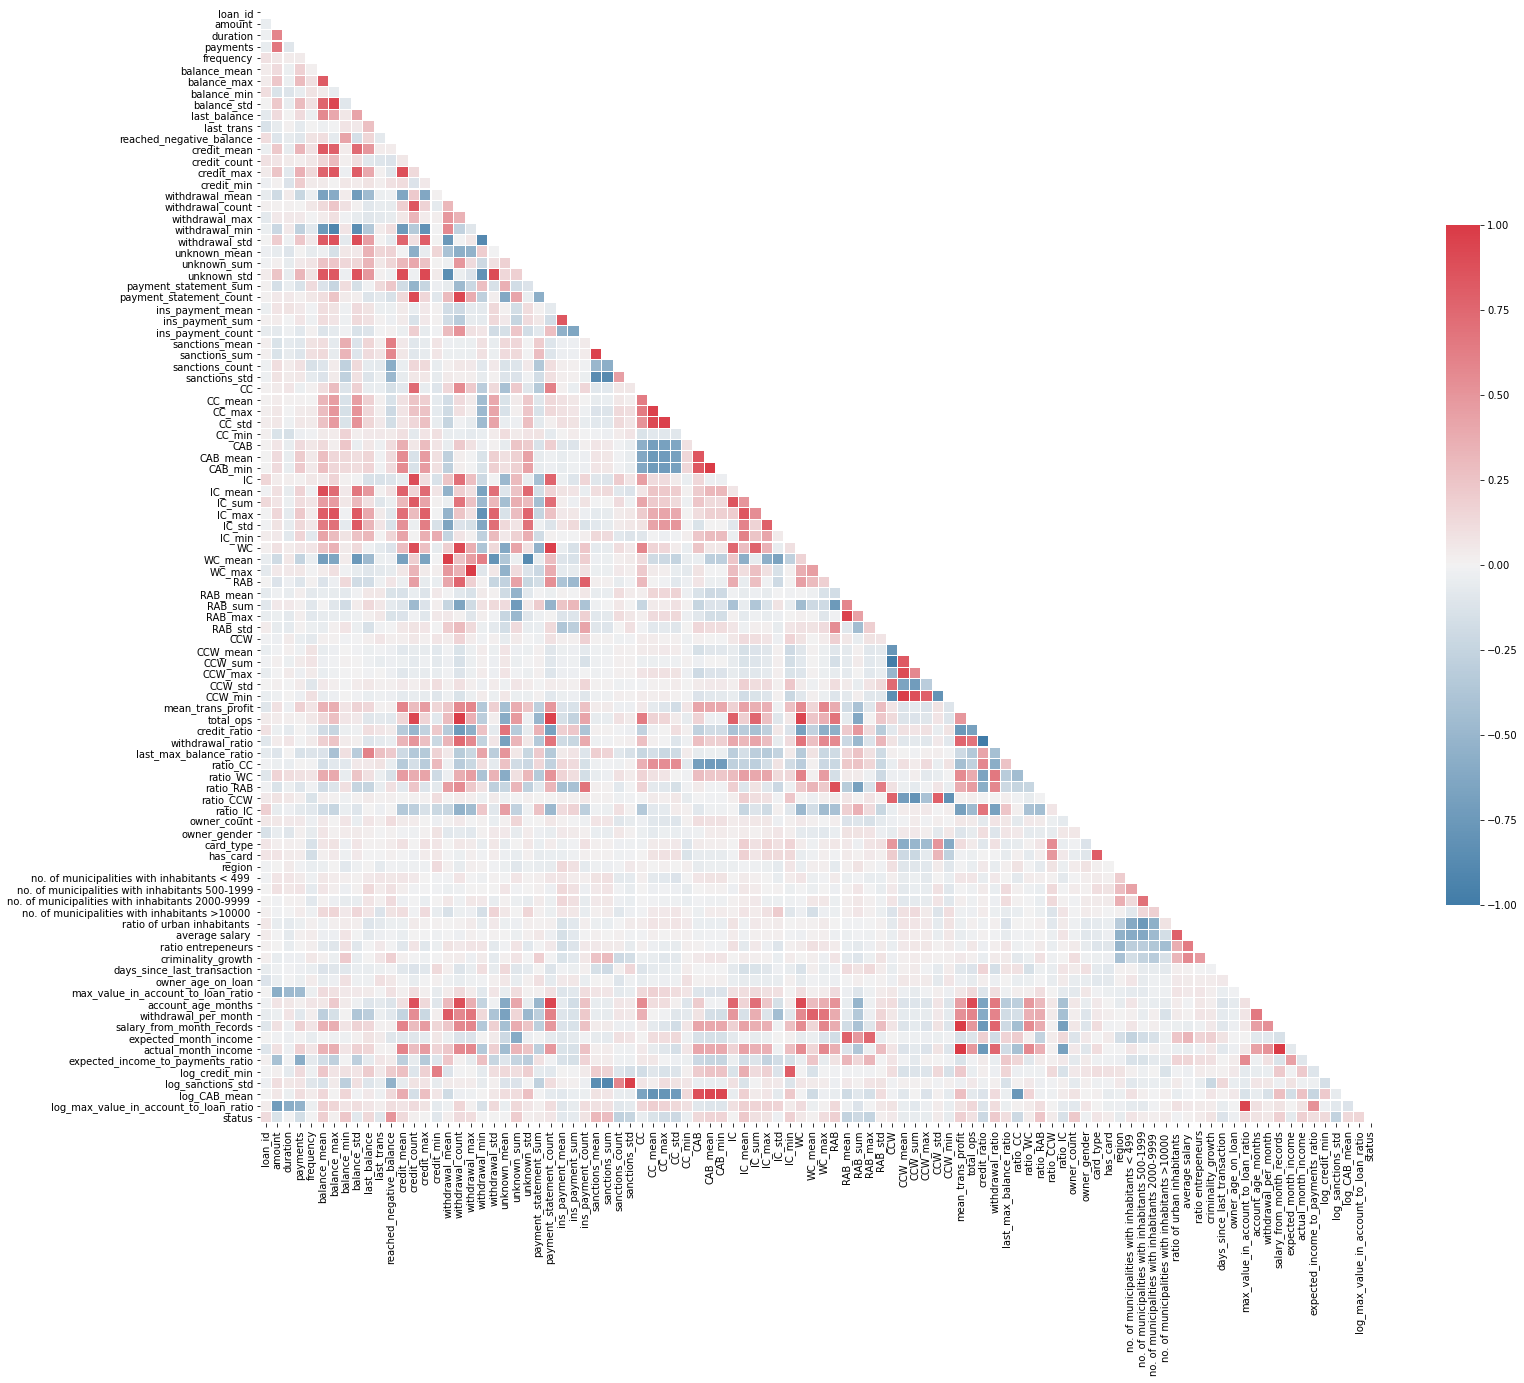

loan_id  amount  duration  payments  frequency  balance_mean  \
0       5314   96396        12      8033          2  12250.000000   
1       5316  165960        36      4610          1  52083.859459   
2       6863  127080        60      2118          1  30060.954167   
3       5325  105804        36      2939          1  41297.480000   
4       7240  274740        60      4579          2  57188.211111   
..       ...     ...       ...       ...        ...           ...   
323     6818  155616        48      3242          1  44197.509884   
324     5625  222180        60      3703          1  55230.444068   
325     6805   45024        48       938          1  41994.907692   
326     7233  115812        36      3217          1  56646.516129   
327     7308  129408        24      5392          1  30869.781308   

     balance_max  balance_min   balance_std  last_balance  last_trans  \
0        20100.0       1100.0   8330.866301       20100.0      3300.0   
1       120512.8        700.0  29122.059454       52208.9     -3419.0   
2        49590.4        800.0  11520.184451       20272.8    -12000.0   
3        65898.5       1000.0  14151.260443       34307.3       178.1   
4       122893.1        600.0  25256.665817       41112.9       -30.0   
..           ...          ...           ...           ...         ...   
323      75294.1        200.0  11044.494392       60694.1    -14600.0   
324     130659.1        800.0  26510.559286       59578.8     -6900.0   
325      63659.3        800.0  13151.510254       38384.3    -17800.0   
326     119527.2       1100.0  21971.162852       41878.1     -3100.0   
327      56055.6       1000.0  11709.142375       24199.5     -4780.0   

     reached_negative_balance   credit_mean  credit_count  credit_max  \
0                         1.0   5025.000000             4      9900.0   
1                         1.0  13523.158824            17     36574.0   
2                         1.0   5009.733333            15     19065.0   
3                         1.0   9254.600000            13     26448.0   
4                         1.0  21255.930769            13     63366.0   
..                        ...           ...           ...         ...   
323                       1.0   6448.582857            70     26388.0   
324                       1.0  13417.557143            28     44352.0   
325                       1.0   8544.930000            20     31636.5   
326                       1.0  16554.986275            51     49887.0   
327                       1.0   8811.758621            29     24212.0   

     credit_min  withdrawal_mean  withdrawal_count  withdrawal_max  \
0        1100.0         0.000000               0.0             0.0   
1           2.9     -8884.240000              20.0           -14.6   
2          48.6     -6097.000000               9.0           -66.0   
3         132.8     -7168.100000              12.0           -14.6   
4          77.1    -16801.000000              14.0           -30.0   
..          ...              ...               ...             ...   
323        23.7     -3830.458824             102.0           -14.6   
324       103.2    -10197.180645              31.0           -14.6   
325        41.0     -6974.431579              19.0           -14.6   
326        51.1    -10992.139726              73.0           -14.6   
327        50.1     -2965.915385              78.0           -14.6   

     withdrawal_min  withdrawal_std  unknown_mean  unknown_sum   unknown_std  \
0               0.0        0.000000   5025.000000      20100.0   3774.806838   
1          -54300.0    14074.800608   2608.833333      62612.0  22249.103350   
2          -14800.0     5390.565972   1966.714286      27534.0  10647.755108   
3          -15600.0     4919.096434   2969.250000      47508.0  13937.959427   
4          -36700.0    13981.924936   2266.000000      40788.0  33727.841554   
..              ...             ...           ...          ...           ...   
323        -36960.0  

In [30]:
def compose_dataset(loan_df, account_df, disp_df, card_df, client_df, trans_df, demogra_df,
                    debug=True, pre_debug=False):
    '''Join the different tables and apply feature engineering'''

    # Pre processment of all the necessary tables
    processed_loan = process_loans(loan_df, pre_debug)
    processed_account = process_account(account_df, pre_debug)
    processed_trans = process_transactions(trans_df, pre_debug)
    processed_disp = process_dispostition(disp_df, pre_debug)
    processed_client = process_client(client_df, pre_debug)
    processed_card = process_card(card_df, pre_debug)
    processed_demogra = process_demographic(demogra_df, pre_debug)
    
    # Joining the different tables
    main_df = processed_loan.merge(processed_account.rename(columns={'date': 'account_creation_date'}),
                                   on='account_id', how='left')\
                            .merge(processed_trans,
                                   on='account_id', how='left')

    # Adding all bank demographic info has negative impact on model performance,
    # since we are feeding irrelevant features
    main_df = main_df.drop(['district_id'], axis=1)

    if debug:
        print(' > Joint table of loans, account, transaction:')
        display(main_df)
        
    ################################################

    df_disp_client_card = processed_disp.merge(processed_client,
                                              on='client_id', how='left')\
                                        .merge(processed_card,
                                              on='disp_id', how='left')
    if debug:
        print(' > Joint table of disposition, client & card:')
        display(df_disp_client_card)
        missing_values(df_disp_client_card)
    
    # Since there are so many, we disconsider the card date columns
    df_disp_client = df_disp_client_card.drop(['issued'], axis=1)
    df_disp_client = clean_numerical_missing_values(df_disp_client, -1)
    

    # Now we aggreggate the remaining data
    # TODO: not yet assure how to handle agg on birthdate and Gender -> using account and district id to get owner
    df_disp_client = df_disp_client.sort_values(by=['account_id', 'type_O'], ascending=[True, False])\
                                   .groupby(['account_id'])\
                                   .agg({
                                       'type_O': ['count'],
                                       'type_U': ['count'],
                                       'gender': get_first,
                                       'birth_date': get_first,
                                       'district_id': get_first,
                                       'type': get_first
                                   })\
                                   .reset_index()
    df_disp_client.columns= ['account_id', 'owner_count', 'disponent_count',
                             'owner_gender', 'owner_birthdate', 'district_id', 'card_type']
    df_disp_client['has_card'] = df_disp_client['card_type']
    df_disp_client.loc[df_disp_client["card_type"] > 0, "has_card"] = 1
    df_disp_client.loc[df_disp_client["card_type"] == 0, "has_card"] = -1
    
    
    if debug:
        print(' > Table after aggreggating data by account_id:')
        display(df_disp_client)
        
    # Now we join the district information regarding the owner
    df_secondary = df_disp_client.merge(processed_demogra, on='district_id')
    
    if debug:
        print(' > Table after joining with the demographics table:')
        display(df_secondary)

    ################################################
    
    # Joining the previously built two major tables
    df = main_df.merge(df_secondary, on='account_id')
    
    # Creating new columns using previous ones
    df['account_age_on_loan'] = (df['date'] - df['account_creation_date']).dt.days
    df['days_since_last_transaction'] = (df['date'] - df['last_trans_date']).dt.days
    df['owner_age_on_loan'] = (df['date'] - df['owner_birthdate']).dt.days / 365
    df["max_value_in_account_to_loan_ratio"] = df["balance_max"] / df["amount"]
    df["last_value_in_account_to_loan_ratio"] = df["last_balance"] / df["amount"]
    #df["date"] = df["date"].astype(int)

    # Stats per month
    df['account_age_months'] = df['account_age_on_loan'] / 30
    df["trans_per_month"] = df['total_ops'] / df["account_age_months"]
    df['credit_per_month'] = df['credit_mean'] / df["account_age_months"]
    df['withdrawal_per_month'] = df['withdrawal_mean'] / df["account_age_months"]
    df['salary_from_month_records'] = df['credit_mean'] + df['withdrawal_mean']
    df['withdrawal_to_credit_month_ratio'] = df['withdrawal_per_month'] / df['credit_per_month']

    # Average salary, pension and household are anual- household value is negative
    df['expected_month_income'] = (df['average salary '] + df['household']) / 12
    df['actual_month_income'] = df['salary_from_month_records'] + (df['household'] / 12)
    df.loc[df["pension"] > 0, "expected_month_income"] = (df["pension"] + df['household']) / 12
    df.loc[df["pension"] > 0, "actual_month_income"] = df["actual_month_income"] + (df['pension'] / 12)
    df['expected_income_to_payments_ratio'] = df['expected_month_income'] / df['payments']
    df['actual_income_to_payments_ratio'] = df['actual_month_income'] / df['payments']
    df['ratio_actual_salary_to_expected'] = df['actual_month_income'] / df['expected_month_income']

    # Using Log transformation on skewed data
    df['log_credit_min'] = log_transform(df['credit_min'])
    df['log_sanctions_std'] = log_transform(df['sanctions_std']) 
    df['log_CAB_sum'] = log_transform(df['CAB_sum']) 
    df['log_CAB_mean'] = log_transform(df['CAB_mean'])
    df['log_max_value_in_account_to_loan_ratio'] = log_transform(df['max_value_in_account_to_loan_ratio'])
    df['log_criminality_growth'] = log_transform(df['criminality_growth'])
    
    # Showing some stats regarding the new features
    if pre_debug:
        print(' > Age of users when requesting a loan, in years')
        column_density_plot(df, 'owner_age_on_loan')
    
    # Dropping useless columns & normalizing others
    df = df.drop(['district_id', 'account_id', 'owner_birthdate',
                 'pension', 'household', 'account_creation_date',
                 'last_trans_date'], axis=1)

    if debug:
        print(' > Obtained dataframe after joining the previous tables and doing some feature engineering over them')
        display(df)
        print(' > And the respective correlations')
        #get_df_correlation(df, (25, 25))
        #print(' > And the respective histograms for the given features')
        #get_features_histogram(df, (20, 75))
        
    ###############################################
    
    # Setting status as last column
    df =  df[[col for col in df if col not in ['status']] + ['status']]
    
    # Automatic and manual features selection
    
    #select_features_FF(df)
    
    #select_features_wrapper(df, dubug=False)
    
    #if debug:
    #    print(' > Applying feature selection')
    #    print(' > Obtained features from feature selection:')
    #    display(filter_features)
        
    #df = df[['loan_id'] + filter_features + ['status']]
    #df = df[['loan_id'] + wrapper_features + ['status']]
    
    df = df[['loan_id'] + ['amount','duration', 'payments', 'frequency', 'balance_mean', 'balance_max', 'balance_min', 'balance_std', 'last_balance', 'last_trans', 'reached_negative_balance', 'credit_mean', 'credit_count', 'credit_max', 'credit_min', 'withdrawal_mean', 'withdrawal_count', 'withdrawal_max', 'withdrawal_min', 'withdrawal_std', 'unknown_mean', 'unknown_sum', 'unknown_std', 'payment_statement_sum', 'payment_statement_count', 'ins_payment_mean', 'ins_payment_sum', 'ins_payment_count', 'sanctions_mean', 'sanctions_sum', 'sanctions_count', 'sanctions_std', 'CC', 'CC_mean', 'CC_max', 'CC_std', 'CC_min', 'CAB', 'CAB_mean', 'CAB_min', 'IC', 'IC_mean', 'IC_sum', 'IC_max', 'IC_std', 'IC_min', 'WC', 'WC_mean', 'WC_max', 'RAB', 'RAB_mean', 'RAB_sum', 'RAB_max', 'RAB_std', 'CCW', 'CCW_mean', 'CCW_sum', 'CCW_max', 'CCW_std', 'CCW_min', 'mean_trans_profit', 'total_ops', 'credit_ratio', 'withdrawal_ratio', 'last_max_balance_ratio', 'ratio_CC', 'ratio_WC', 'ratio_RAB', 'ratio_CCW', 'ratio_IC', 'owner_count', 'owner_gender', 'card_type', 'has_card', 'region', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ', 'ratio of urban inhabitants ', 'average salary ', 'ratio entrepeneurs', 'criminality_growth', 'days_since_last_transaction', 'owner_age_on_loan', 'max_value_in_account_to_loan_ratio', 'account_age_months', 'withdrawal_per_month', 'salary_from_month_records', 'expected_month_income', 'actual_month_income', 'expected_income_to_payments_ratio', 'log_credit_min', 'log_sanctions_std', 'log_CAB_mean', 'log_max_value_in_account_to_loan_ratio'] + ['status']]
    
    ###############################################

    if debug:
        print(' >>> Final table that will serve as input to the model:')
        display(df)
        print(' > And the respective correlations')
        get_df_correlation(df, (25, 25))

    return df
        
        
        
dataset = compose_dataset(loan_df, account_df, disp_df, card_df, client_df,
                          trans_df, demogra_df, debug=True, pre_debug=False)
display(dataset)

In [28]:
def write_df_to_csv(df, directory, filename):
    '''Write the content of a dataframe to a csv file'''
    csv = df.to_csv(index=False)

    os.makedirs(directory, exist_ok=True)
    output_path = '%s/%s' % (directory, filename)

    with open(output_path, 'w') as fd:
        fd.write(csv)

 > Joint table of loans, account, transaction:


loan_id  account_id       date  amount  duration  payments  status  \
0       5895        4473 1997-01-03   93960        60      1566     NaN   
1       7122       10365 1997-01-04  260640        36      7240     NaN   
2       6173        5724 1997-01-08  232560        48      4845     NaN   
3       6142        5591 1997-01-21  221880        60      3698     NaN   
4       5358        2018 1997-01-21   38520        12      3210     NaN   
..       ...         ...        ...     ...       ...       ...     ...   
349     4989         105 1998-12-05  352704        48      7348     NaN   
350     5221        1284 1998-12-05   52512        12      4376     NaN   
351     6402        6922 1998-12-06  139488        24      5812     NaN   
352     5346        1928 1998-12-06   55632        24      2318     NaN   
353     6748        8645 1998-12-08  240900        60      4015     NaN   

     frequency account_creation_date  balance_mean  balance_max  balance_min  \
0            1            1995-10-09  54520.202247      88246.7        800.0   
1            1            1995-09-02  31518.182051      88731.8       -718.6   
2            0            1995-04-19  40175.612500      79286.6        200.0   
3            1            1996-03-16  44440.912676      74216.8       1000.0   
4            1            1995-06-04  20231.313158      31302.0        900.0   
..         ...                   ...           ...          ...          ...   
349          1            1997-07-10  30797.487500      74693.6        800.0   
350          1            1997-07-02  59684.298851     120419.7       1000.0   
351          2            1997-05-12  46755.305769      95976.0       1100.0   
352          1            1997-03-02  29645.320175      52896.1        500.0   
353          1            1997-06-23  26268.190000      59731.2        700.0   

      balance_std  last_balance  first_balance last_trans_date  last_trans  \
0    13768.555214       49548.5          800.0      1997-01-01    -19700.0   
1    20629.925861       11565.4         1000.0      1997-01-01     12284.0   
2    15672.003047       45754.0          200.0      1997-01-07     -2692.0   
3    13853.751837       38913.4         1000.0      1997-01-13     -2872.0   
4     4462.709852       18914.3          900.0      1997-01-14     -3115.0   
..            ...           ...            ...             ...         ...   
349  16415.401618       35875.3          800.0      1998-12-02     12100.0   
350  22496.238341       41035.4         1000.0      1998-11-30       -14.6   
351  22242.034248       47956.3         1100.0      1998-12-03    -25500.0   
352  11976.126778       38449.2          500.0      1998-11-30       -14.6   
353  10061.747545       19813.8          700.0      1998-12-05     -8919.0   

     reached_negative_balance   credit_mean  credit_count  credit_max  \
0                         1.0  12769.220000            30     36637.5   
1                        -1.0   9526.772414            29     41871.0   
2                         1.0  15302.486047            43     43605.0   
3                         1.0  11797.642857            21     33280.0   
4                         1.0   2736.026923            52      8800.0   
..                        ...           ...           ...         ...   
349                       1.0   8806.779310            29     49101.0   
350                       1.0  14839.705263            38     49972.0   
351                       1.0  17969.630769            39     52305.0   
352                       1.0   7270.390000            50     20858.0   
353                       1.0   5791.309259            54     25394.0   

     credit_min    credit_std  withdrawal_mean  withdrawal_count  \
0          82.2  14018.915135     -5653.016949              59.0   
1          15.5  14395.797544     -5402.261224              49.0   
2          45.7  16313.366967     -4603.406015             133.0   
3          54.2  12714.278533     -4176.740000           

 > Joint table of disposition, client & card:


disp_id  client_id  account_id  type_O  type_U  district_id  gender  \
0           1          1           1       1       0           18       1   
1           2          2           2       1       0            1       0   
2           3          3           2       0       1            1       1   
3           4          4           3       1       0            5       0   
4           5          5           3       0       1            5       1   
...       ...        ...         ...     ...     ...          ...     ...   
5364    13647      13955       11349       1       0            1       1   
5365    13648      13956       11349       0       1            1       0   
5366    13660      13968       11359       1       0           61       0   
5367    13663      13971       11362       1       0           67       1   
5368    13690      13998       11382       1       0           74       1   

     birth_date  type     issued  
0    1970-12-13   NaN        NaT  
1    1945-02-04   NaN        NaT  
2    1940-10-09   NaN        NaT  
3    1956-12-01   NaN        NaT  
4    1960-07-03   NaN        NaT  
...         ...   ...        ...  
5364 1945-10-30   NaN        NaT  
5365 1943-04-06   NaN        NaT  
5366 1968-04-13   0.0 1995-06-13  
5367 1962-10-19   NaN        NaT  
5368 1953-08-12   NaN        NaT  

[5369 rows x 10 columns]

disp_id        0.000000
client_id      0.000000
account_id     0.000000
type_O         0.000000
type_U         0.000000
district_id    0.000000
gender         0.000000
birth_date     0.000000
type           0.962377
issued         0.962377
dtype: float64

 > Table after aggreggating data by account_id:


account_id  owner_count  disponent_count  owner_gender owner_birthdate  \
0              1            1                1             1      1970-12-13   
1              2            2                2             0      1945-02-04   
2              3            2                2             0      1956-12-01   
3              4            1                1             0      1919-09-22   
4              5            1                1             0      1929-01-25   
...          ...          ...              ...           ...             ...   
4495       11333            1                1             0      1942-01-01   
4496       11349            2                2             1      1945-10-30   
4497       11359            1                1             0      1968-04-13   
4498       11362            1                1             1      1962-10-19   
4499       11382            1                1             1      1953-08-12   

      district_id  card_type  has_card  
0              18       -1.0      -1.0  
1               1       -1.0      -1.0  
2               5       -1.0      -1.0  
3              12       -1.0      -1.0  
4              15       -1.0      -1.0  
...           ...        ...       ...  
4495            8       -1.0      -1.0  
4496            1       -1.0      -1.0  
4497           61        0.0      -1.0  
4498           67       -1.0      -1.0  
4499           74       -1.0      -1.0  

[4500 rows x 8 columns]

 > Table after joining with the demographics table:


account_id  owner_count  disponent_count  owner_gender owner_birthdate  \
0              1            1                1             1      1970-12-13   
1            343            1                1             0      1978-03-13   
2            413            1                1             1      1935-07-08   
3            431            1                1             0      1980-04-13   
4            568            1                1             0      1979-10-21   
...          ...          ...              ...           ...             ...   
4495        7990            1                1             1      1967-03-17   
4496        8039            1                1             0      1972-06-23   
4497        8153            1                1             0      1974-04-23   
4498        9153            2                2             0      1938-09-25   
4499        9504            1                1             0      1949-04-14   

      district_id  card_type  has_card  region  no. of inhabitants  \
0              18       -1.0      -1.0       5               70699   
1              18       -1.0      -1.0       5               70699   
2              18       -1.0      -1.0       5               70699   
3              18       -1.0      -1.0       5               70699   
4              18       -1.0      -1.0       5               70699   
...           ...        ...       ...     ...                 ...   
4495            9       -1.0      -1.0       1               81344   
4496            9       -1.0      -1.0       1               81344   
4497            9       -1.0      -1.0       1               81344   
4498            9       -1.0      -1.0       1               81344   
4499            9        0.0      -1.0       1               81344   

      no. of municipalities with inhabitants < 499   \
0                                                60   
1                                                60   
2                                                60   
3                                                60   
4                                                60   
...                                             ...   
4495                                             61   
4496                                             61   
4497                                             61   
4498                                             61   
4499                                             61   

      no. of municipalities with inhabitants 500-1999  \
0                                                  13   
1                                                  13   
2                                                  13   
3                                                  13   
4                                                  13   
...                                               ...   
4495                                               23   
4496                                               23   
4497                                               23   
4498                                               23   
4499                                               23   

      no. of municipalities with inhabitants 2000-9999   \
0                                                     2   
1                                                     2   
2                                                     2   
3                                                     2   
4                                                     2   
...                                                 ...   
4495                                                  4   
4496                                                  4   
4497                                                  4   
4498                                                  4   
4499                                                  4   

      no. of municipalities with inhabitants >10000   no. of cities   \
0                                                  1               4   
1    

 > Obtained dataframe after joining the previous tables and doing some feature engineering over them


loan_id       date  amount  duration  payments  status  frequency  \
0       5895 1997-01-03   93960        60      1566     NaN          1   
1       7122 1997-01-04  260640        36      7240     NaN          1   
2       6173 1997-01-08  232560        48      4845     NaN          0   
3       6142 1997-01-21  221880        60      3698     NaN          1   
4       5358 1997-01-21   38520        12      3210     NaN          1   
..       ...        ...     ...       ...       ...     ...        ...   
349     4989 1998-12-05  352704        48      7348     NaN          1   
350     5221 1998-12-05   52512        12      4376     NaN          1   
351     6402 1998-12-06  139488        24      5812     NaN          2   
352     5346 1998-12-06   55632        24      2318     NaN          1   
353     6748 1998-12-08  240900        60      4015     NaN          1   

     balance_mean  balance_max  balance_min   balance_std  last_balance  \
0    54520.202247      88246.7        800.0  13768.555214       49548.5   
1    31518.182051      88731.8       -718.6  20629.925861       11565.4   
2    40175.612500      79286.6        200.0  15672.003047       45754.0   
3    44440.912676      74216.8       1000.0  13853.751837       38913.4   
4    20231.313158      31302.0        900.0   4462.709852       18914.3   
..            ...          ...          ...           ...           ...   
349  30797.487500      74693.6        800.0  16415.401618       35875.3   
350  59684.298851     120419.7       1000.0  22496.238341       41035.4   
351  46755.305769      95976.0       1100.0  22242.034248       47956.3   
352  29645.320175      52896.1        500.0  11976.126778       38449.2   
353  26268.190000      59731.2        700.0  10061.747545       19813.8   

     first_balance  last_trans  reached_negative_balance   credit_mean  \
0            800.0    -19700.0                       1.0  12769.220000   
1           1000.0     12284.0                      -1.0   9526.772414   
2            200.0     -2692.0                       1.0  15302.486047   
3           1000.0     -2872.0                       1.0  11797.642857   
4            900.0     -3115.0                       1.0   2736.026923   
..             ...         ...                       ...           ...   
349          800.0     12100.0                       1.0   8806.779310   
350         1000.0       -14.6                       1.0  14839.705263   
351         1100.0    -25500.0                       1.0  17969.630769   
352          500.0       -14.6                       1.0   7270.390000   
353          700.0     -8919.0                       1.0   5791.309259   

     credit_count  credit_max  credit_min    credit_std  withdrawal_mean  \
0              30     36637.5        82.2  14018.915135     -5653.016949   
1              29     41871.0        15.5  14395.797544     -5402.261224   
2              43     43605.0        45.7  16313.366967     -4603.406015   
3              21     33280.0        54.2  12714.278533     -4176.740000   
4              52      8800.0        19.8   2601.941063     -2069.016129   
..            ...         ...         ...           ...              ...   
349            29     49101.0        38.0  14409.085314     -8341.525926   
350            38     49972.0        10.9  16135.687297    -10670.889796   
351            39     52305.0        87.3  19237.348707    -10043.984615   
352            50     20858.0        36.8   7339.187406     -5079.221875   
353            54     25394.0        20.5   8454.790807     -4438.133333   

     withdrawal_count  withdrawal_max  withdrawal_min  withdrawal_std  \
0                59.0           -14.6        -30000.0     6378.603783   
1                49.0            -4.6        -30000.0     6867.326115   
2               133.0          -100.0        -29100.0     6141.604106   
3                50.0            -2.0        -21200.0     5570.455132   
4                62.0           -14.6         -5

 > And the respective correlations
 >>> Final table that will serve as input to the model:


loan_id  amount  duration  payments  frequency  balance_mean  \
0       5895   93960        60      1566          1  54520.202247   
1       7122  260640        36      7240          1  31518.182051   
2       6173  232560        48      4845          0  40175.612500   
3       6142  221880        60      3698          1  44440.912676   
4       5358   38520        12      3210          1  20231.313158   
..       ...     ...       ...       ...        ...           ...   
349     4989  352704        48      7348          1  30797.487500   
350     5221   52512        12      4376          1  59684.298851   
351     6402  139488        24      5812          2  46755.305769   
352     5346   55632        24      2318          1  29645.320175   
353     6748  240900        60      4015          1  26268.190000   

     balance_max  balance_min   balance_std  last_balance  last_trans  \
0        88246.7        800.0  13768.555214       49548.5    -19700.0   
1        88731.8       -718.6  20629.925861       11565.4     12284.0   
2        79286.6        200.0  15672.003047       45754.0     -2692.0   
3        74216.8       1000.0  13853.751837       38913.4     -2872.0   
4        31302.0        900.0   4462.709852       18914.3     -3115.0   
..           ...          ...           ...           ...         ...   
349      74693.6        800.0  16415.401618       35875.3     12100.0   
350     120419.7       1000.0  22496.238341       41035.4       -14.6   
351      95976.0       1100.0  22242.034248       47956.3    -25500.0   
352      52896.1        500.0  11976.126778       38449.2       -14.6   
353      59731.2        700.0  10061.747545       19813.8     -8919.0   

     reached_negative_balance   credit_mean  credit_count  credit_max  \
0                         1.0  12769.220000            30     36637.5   
1                        -1.0   9526.772414            29     41871.0   
2                         1.0  15302.486047            43     43605.0   
3                         1.0  11797.642857            21     33280.0   
4                         1.0   2736.026923            52      8800.0   
..                        ...           ...           ...         ...   
349                       1.0   8806.779310            29     49101.0   
350                       1.0  14839.705263            38     49972.0   
351                       1.0  17969.630769            39     52305.0   
352                       1.0   7270.390000            50     20858.0   
353                       1.0   5791.309259            54     25394.0   

     credit_min  withdrawal_mean  withdrawal_count  withdrawal_max  \
0          82.2     -5653.016949              59.0           -14.6   
1          15.5     -5402.261224              49.0            -4.6   
2          45.7     -4603.406015             133.0          -100.0   
3          54.2     -4176.740000              50.0            -2.0   
4          19.8     -2069.016129              62.0           -14.6   
..          ...              ...               ...             ...   
349        38.0     -8341.525926              27.0           -14.6   
350        10.9    -10670.889796              49.0           -14.6   
351        87.3    -10043.984615              65.0           -30.0   
352        36.8     -5079.221875              64.0           -14.6   
353        20.5     -4438.133333              66.0           -14.6   

     withdrawal_min  withdrawal_std  unknown_mean  unknown_sum   unknown_std  \
0          -30000.0     6378.603783   1718.883929      96257.5  16177.970922   
1          -30000.0     6867.326115    870.534884      37433.0  16890.801783   
2          -29100.0     6141.604106    835.541284      91074.0  16344.032507   
3          -21200.0     5570.455132    922.222222      41500.0  13906.157514   
4           -5400.0     1429.308427    976.375000      62488.0   3796.749535   
..              ...             ...           ...          ...           ...   
349        -29900.0  

 > And the respective correlations


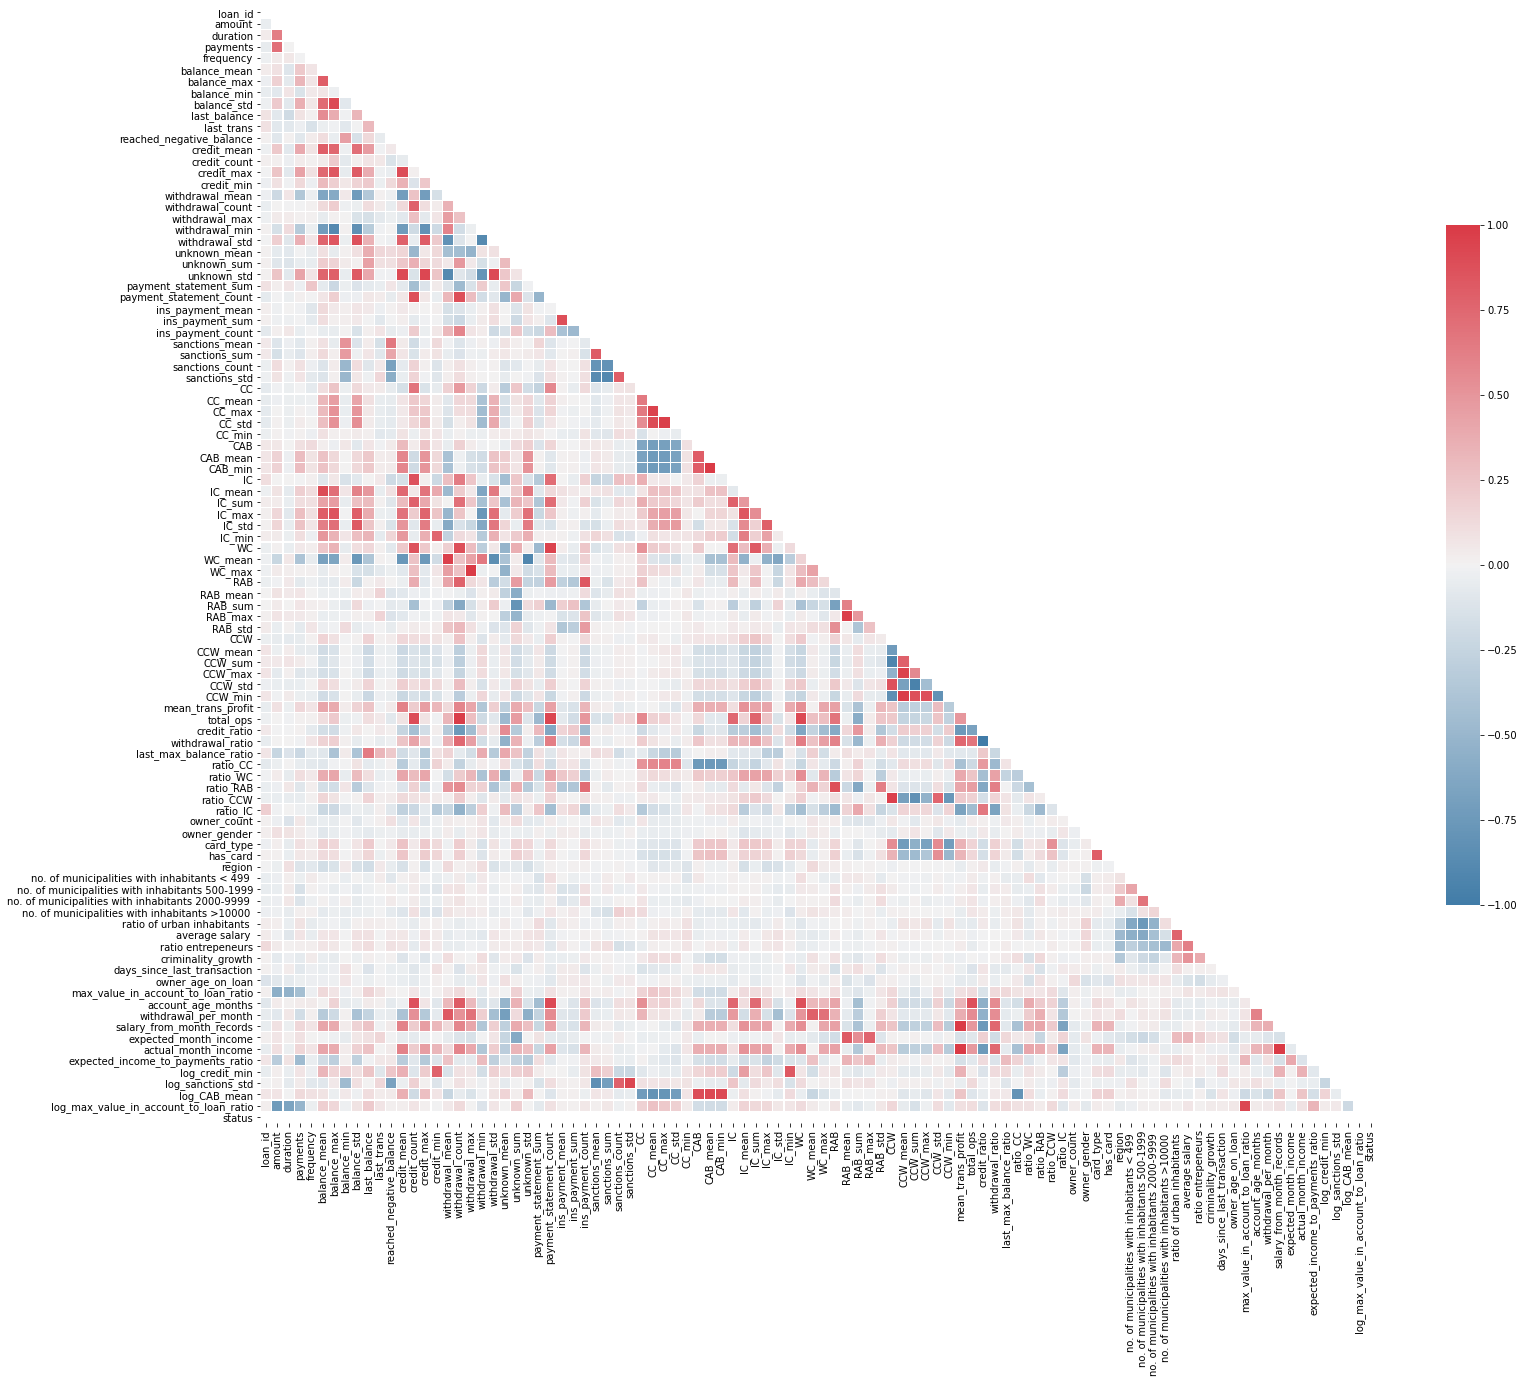

In [32]:

#dataset = process_transactions(trans_df, True)
#write_df_to_csv(dataset, 'dataset', 'preprocessed_transactions.csv')

# Outputting the resultant table to a final csv
#write_df_to_csv(dataset, 'dataset', 'preprocessed_data_wrapper.csv')

test_dataset = compose_dataset(loan_test_df, account_df, disp_df, card_test_df, client_df, trans_test_df, demogra_df)
write_df_to_csv(test_dataset, 'dataset', 'test_dataset_wrapper.csv')